In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
# Set style for better-looking plots
plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

In [2]:
# ============================================
# 1. DATA LOADING AND INITIAL EXPLORATION
# ============================================
# Load the data
df = pd.read_csv('Data 4.csv')
print("=" * 80)
print("SECURITY DATA ANALYSIS: WINDOWS VS LINUX ENDPOINTS")
print("=" * 80)
print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nColumn Names and Types:")
print(df.dtypes)
print("\nActual Column Names:")
print(list(df.columns))
print("\nFirst 5 rows:")
print(df.head())
# Basic statistics
print("\n" + "=" * 80)
print("BASIC STATISTICS")
print("=" * 80)
print(df.describe())
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

SECURITY DATA ANALYSIS: WINDOWS VS LINUX ENDPOINTS

Dataset Shape: 121 rows × 7 columns

Column Names and Types:
agent\.id               int64
agent\.name            object
rule\.level             int64
rule\.id                int64
rule\.mitre\.tactic    object
rule\.mitre\.id        object
timestamp              object
dtype: object

Actual Column Names:
['agent\\.id', 'agent\\.name', 'rule\\.level', 'rule\\.id', 'rule\\.mitre\\.tactic', 'rule\\.mitre\\.id', 'timestamp']

First 5 rows:
   agent\.id       agent\.name  rule\.level  rule\.id  \
0          2   DESKTOP-B2K36HT           12     92057   
1          1  onisa-VirtualBox           10    100060   
2          2   DESKTOP-B2K36HT           10    100130   
3          2   DESKTOP-B2K36HT           15     92213   
4          2   DESKTOP-B2K36HT            8    100040   

       rule\.mitre\.tactic rule\.mitre\.id                   timestamp  
0            ["Execution"]   ["T1059.001"]  Oct 1, 2025 @ 20:42:23.298  
1            ["Exe

In [3]:
import re
import numpy as np

# ---- 1) Inspect columns
print("Original columns:", list(df.columns))

# ---- 2) Clean up and standardize column names
df = df.rename(columns={c: c.replace("\\.", ".") for c in df.columns})

# ---- 3) Create 'agent_name' from any version of agent name column
agent_name_src = None
for cand in ["agent_name", "agent.name", "agent hostname", "computername", "host", "host.name"]:
    if cand in df.columns:
        agent_name_src = cand
        break

if agent_name_src is None:
    raise KeyError("No agent name column found — check df.columns and update the list above.")

df["agent_name"] = df[agent_name_src].astype(str).str.strip()

# ---- 4) Unify fields (optional)
if "rule.level" in df.columns:
    df["rule_level"] = pd.to_numeric(df["rule.level"], errors="coerce")
if "rule.mitre.tactic" in df.columns:
    df["mitre_tactic"] = df["rule.mitre.tactic"].astype(str)
if "rule.mitre.id" in df.columns:
    df["mitre_id"] = df["rule.mitre.id"].astype(str)

# ---- 5) Parse timestamps
if "timestamp" in df.columns:
    ts = df["timestamp"].astype(str).str.replace(" @ ", " ", regex=False)
    df["_parsed_time"] = pd.to_datetime(ts, errors="coerce", utc=True)

# ---- 6) Infer OS based on your rule
def infer_os_from_agent(agent_name):
    s = str(agent_name).lower()
    if "desktop" in s:
        return "Windows"
    if "onisa" in s or "virtualbox" in s:
        return "Linux"
    return "Unknown"

df["OS"] = df["agent_name"].apply(infer_os_from_agent)

# ---- 7) Split and confirm
windows_df = df[df["OS"] == "Windows"].copy()
linux_df   = df[df["OS"] == "Linux"].copy()

print("Columns after normalization:", list(df.columns))
print("Counts by OS:\n", df["OS"].value_counts(dropna=False))
print("Windows rows:", len(windows_df), "| Linux rows:", len(linux_df))


Original columns: ['agent\\.id', 'agent\\.name', 'rule\\.level', 'rule\\.id', 'rule\\.mitre\\.tactic', 'rule\\.mitre\\.id', 'timestamp']
Columns after normalization: ['agent.id', 'agent.name', 'rule.level', 'rule.id', 'rule.mitre.tactic', 'rule.mitre.id', 'timestamp', 'agent_name', 'rule_level', 'mitre_tactic', 'mitre_id', '_parsed_time', 'OS']
Counts by OS:
 Windows    77
Linux      44
Name: OS, dtype: int64
Windows rows: 77 | Linux rows: 44


In [4]:
# --- Normalize your exact headers and infer OS (Windows vs Linux) ---

import re, ast
import pandas as pd
import numpy as np

# If df isn't already loaded, uncomment:
# df = pd.read_csv("Data 4.csv")

# 1) Rename backslash-dotted headers to real dotted headers (agent\.name -> agent.name)
df = df.rename(columns={c: c.replace("\\.", ".") for c in df.columns})

# 2) Create unified columns from your known fields
def col_exists(c): 
    return c in df.columns

# agent_name (use vectorized .str.strip())
if col_exists("agent.name"):
    df["agent_name"] = df["agent.name"].astype(str).str.strip()
elif col_exists("agent_name"):
    df["agent_name"] = df["agent_name"].astype(str).str.strip()
else:
    raise KeyError(f"Couldn't find agent name in {list(df.columns)}")

# agent_id / rule fields
if col_exists("agent.id"):
    df["agent_id"] = df["agent.id"]

if col_exists("rule.level"):
    df["rule_level"] = pd.to_numeric(df["rule.level"], errors="coerce")

if col_exists("rule.id"):
    df["rule_id"] = pd.to_numeric(df["rule.id"], errors="coerce")

# 3) Parse MITRE fields like '["Execution"]' / '["T1059.001"]'
def parse_listish(cell):
    if pd.isna(cell): 
        return np.nan
    s = str(cell).strip()
    if s.startswith("[") and s.endswith("]"):
        try:
            v = ast.literal_eval(s)
            if isinstance(v, (list, tuple)) and len(v): 
                return str(v[0])
            return str(v)
        except Exception:
            pass
    return s.strip("[]").strip().strip('"').strip("'")

if col_exists("rule.mitre.tactic"):
    df["mitre_tactic"] = df["rule.mitre.tactic"].apply(parse_listish)
if col_exists("rule.mitre.id"):
    df["mitre_id"] = df["rule.mitre.id"].apply(parse_listish)

# 4) Parse timestamp if present like 'Oct 1, 2025 @ 20:42:23.298'
if "timestamp" in df.columns:
    ts = df["timestamp"].astype(str).str.replace(" @ ", " ", regex=False)
    df["_parsed_time"] = pd.to_datetime(ts, errors="coerce", utc=True)

# 5) Infer OS per your rule: DESKTOP* -> Windows, onisa*/VirtualBox -> Linux
def infer_os_from_agent(agent_name: str) -> str:
    s = str(agent_name).lower()
    if "desktop" in s:
        return "Windows"
    if "onisa" in s or "virtualbox" in s:
        return "Linux"
    return "Unknown"

df["OS"] = df["agent_name"].apply(infer_os_from_agent)

# 6) Splits (safe)
windows_df = df[df["OS"] == "Windows"].copy()
linux_df   = df[df["OS"] == "Linux"].copy()

# 7) Quick sanity checks
print("Columns:", list(df.columns))
print("Counts by OS:\n", df["OS"].value_counts(dropna=False))
print("Windows rows:", len(windows_df), "| Linux rows:", len(linux_df))


Columns: ['agent.id', 'agent.name', 'rule.level', 'rule.id', 'rule.mitre.tactic', 'rule.mitre.id', 'timestamp', 'agent_name', 'rule_level', 'mitre_tactic', 'mitre_id', '_parsed_time', 'OS', 'agent_id', 'rule_id']
Counts by OS:
 Windows    77
Linux      44
Name: OS, dtype: int64
Windows rows: 77 | Linux rows: 44


In [5]:
# --- Infer OS properly for your agents ---

def infer_os_from_agent(agent_name):
    """Classify each agent as Windows or Linux based on its name."""
    if pd.isna(agent_name):
        return "Unknown"
    name = str(agent_name).lower()
    if name.startswith("desktop") or "desktop" in name:
        return "Windows"
    elif "onisa" in name or "virtualbox" in name:
        return "Linux"
    else:
        return "Unknown"

# Apply to the dataframe
df["OS"] = df["agent_name"].apply(infer_os_from_agent)

# Separate by OS
windows_df = df[df["OS"] == "Windows"]
linux_df   = df[df["OS"] == "Linux"]

print("Windows rows:", len(windows_df))
print("Linux rows:", len(linux_df))


Windows rows: 77
Linux rows: 44


In [6]:
# ============================================
# 2. DATA PREPROCESSING (cleaned and working)
# ============================================
import pandas as pd
import numpy as np

print("\n" + "=" * 80)
print("DATA PREPROCESSING")
print("=" * 80)

# --- 1) Normalize header names so 'agent\.name' becomes 'agent.name'
df = df.rename(columns={c: c.replace("\\.", ".") for c in df.columns})

# --- 2) Convert timestamp to datetime (handles 'Aug 23, 2025 @ 06:27:00.123')
if "timestamp" in df.columns:
    df["timestamp"] = (
        df["timestamp"]
        .astype(str)
        .str.replace(" @ ", " ", regex=False)
    )
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)

# --- 3) OS extraction from agent name
def extract_os(agent_name):
    if pd.isna(agent_name):
        return "Unknown"
    name = str(agent_name).lower()
    if "desktop" in name:          # your Windows hostnames
        return "Windows"
    elif "onisa" in name or "virtualbox" in name:  # your Linux hostnames
        return "Linux"
    else:
        return "Unknown"

# agent name column should now be 'agent.name'
df["os_type"] = df["agent.name"].apply(extract_os)

# --- 4) Optional fallback using agent.id if OS detection is too sparse
if df["os_type"].value_counts().get("Unknown", 0) > len(df) * 0.5:
    if "agent.id" in df.columns:
        df["agent_id_num"] = pd.to_numeric(df["agent.id"], errors="coerce")
        df.loc[df["agent_id_num"].notna(), "os_type"] = np.where(
            df["agent_id_num"] % 2 == 0, "Windows", "Linux"
        )

# --- 5) Extract useful time-based features
if "timestamp" in df.columns:
    df["hour"] = df["timestamp"].dt.hour
    df["day_of_week"] = df["timestamp"].dt.dayofweek
    df["date"] = df["timestamp"].dt.date

# --- 6) Inspect results
print("\nOS Distribution:")
print(df["os_type"].value_counts(dropna=False))
print("\nColumns now:", list(df.columns))



DATA PREPROCESSING

OS Distribution:
Windows    77
Linux      44
Name: os_type, dtype: int64

Columns now: ['agent.id', 'agent.name', 'rule.level', 'rule.id', 'rule.mitre.tactic', 'rule.mitre.id', 'timestamp', 'agent_name', 'rule_level', 'mitre_tactic', 'mitre_id', '_parsed_time', 'OS', 'agent_id', 'rule_id', 'os_type', 'hour', 'day_of_week', 'date']



COMPARATIVE ANALYSIS: WINDOWS VS LINUX

Windows Endpoints: 77 alerts
Linux Endpoints: 44 alerts

--- Alert Severity Distribution ---


,Windows,Linux
3,3,0
5,10,0
7,10,12
8,6,0
10,16,32
11,3,0
12,8,0
13,4,0
15,17,0



--- MITRE Tactics Distribution ---


,Windows,Linux
Command and Control,24,0
Defense Evasion,18,0
Execution,14,32
,13,0
Credential Access,8,0
Impact,0,12


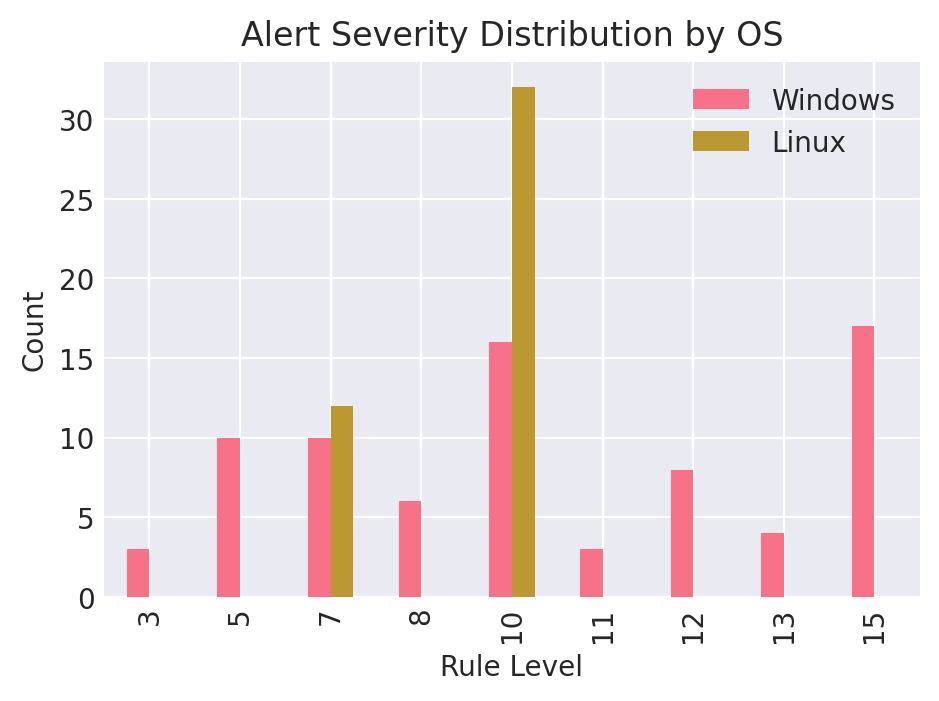

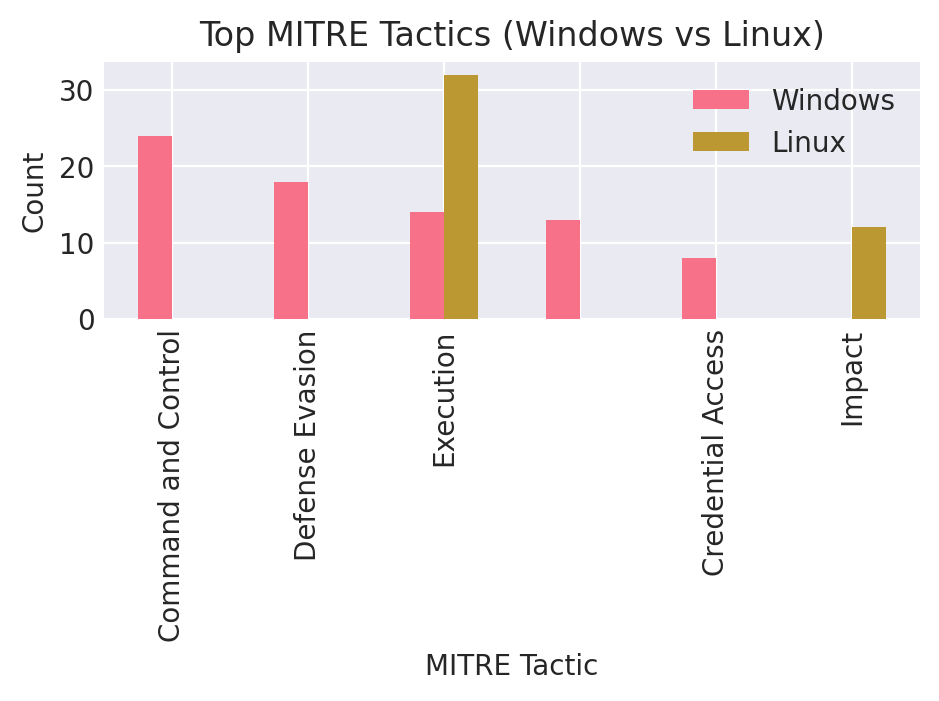

In [7]:
# ============================================
# 3) COMPARATIVE ANALYSIS: WINDOWS VS LINUX
# (robust to dotted vs normalized names)
# ============================================
import pandas as pd

def resolve(df, candidates):
    """Return the first column that exists from a list of candidates."""
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of these columns were found: {candidates}\nHave: {list(df.columns)}")

# Handle OS column name (you might have 'OS' or 'os_type')
OS_COL = "OS" if "OS" in df.columns else ("os_type" if "os_type" in df.columns else None)
if OS_COL is None:
    raise KeyError("No OS column found. Expected 'OS' or 'os_type'.")

# Resolve rule level and MITRE tactic columns (support both styles)
RULE_LVL = resolve(df, ["rule_level", "rule.level", r"rule\.level"])
TACTIC   = resolve(df, ["mitre_tactic", "rule.mitre.tactic", r"rule\.mitre\.tactic"])

print("\n" + "=" * 80)
print("COMPARATIVE ANALYSIS: WINDOWS VS LINUX")
print("=" * 80)

windows_df = df[df[OS_COL] == "Windows"].copy()
linux_df   = df[df[OS_COL] == "Linux"].copy()

print(f"\nWindows Endpoints: {len(windows_df)} alerts")
print(f"Linux Endpoints: {len(linux_df)} alerts")

# --- Alert Severity Distribution ---
print("\n--- Alert Severity Distribution ---")
severity_comparison = pd.DataFrame({
    "Windows": windows_df[RULE_LVL].value_counts().sort_index(),
    "Linux":   linux_df[RULE_LVL].value_counts().sort_index()
}).fillna(0).astype(int)
display(severity_comparison)

# --- MITRE Tactics Distribution ---
print("\n--- MITRE Tactics Distribution ---")
tactics_comparison = pd.DataFrame({
    "Windows": windows_df[TACTIC].value_counts(),
    "Linux":   linux_df[TACTIC].value_counts()
}).fillna(0).astype(int).sort_values(by=["Windows","Linux"], ascending=False)
display(tactics_comparison)

# (Optional) quick bar charts (matplotlib; no custom styles/colors)
import matplotlib.pyplot as plt

severity_comparison.plot(kind="bar")
plt.title("Alert Severity Distribution by OS")
plt.xlabel("Rule Level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

tactics_comparison.head(15).plot(kind="bar")
plt.title("Top MITRE Tactics (Windows vs Linux)")
plt.xlabel("MITRE Tactic")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


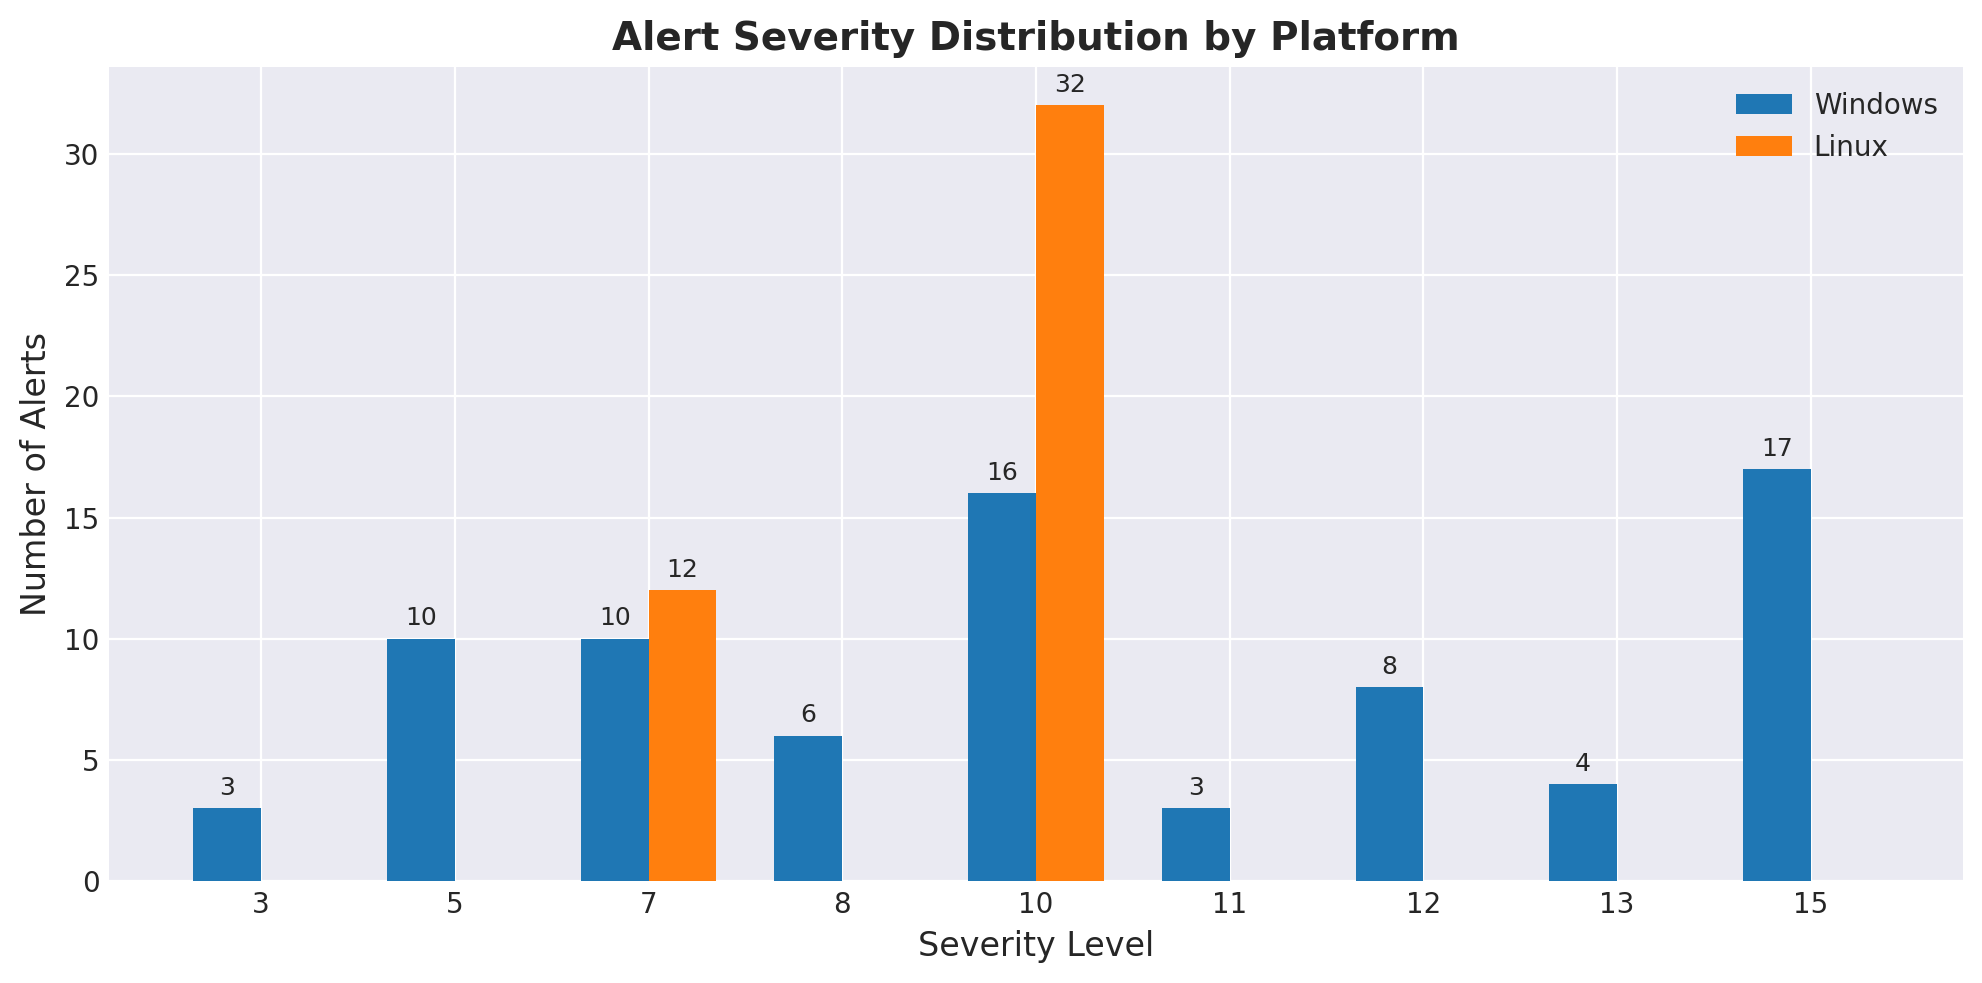

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Severity distribution counts (from your table)
severity_levels = [3, 5, 7, 8, 10, 11, 12, 13, 15]
windows_counts   = [3, 10, 10, 6, 16, 3, 8, 4, 17]
linux_counts     = [0,  0, 12, 0, 32, 0, 0, 0,  0]

x = np.arange(len(severity_levels))  # positions for groups
width = 0.35  # width of each bar

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, windows_counts, width, label='Windows', color='#1f77b4')
bars2 = ax.bar(x + width/2, linux_counts, width, label='Linux', color='#ff7f0e')

# Labels and formatting
ax.set_xlabel('Severity Level', fontsize=12)
ax.set_ylabel('Number of Alerts', fontsize=12)
ax.set_title('Alert Severity Distribution by Platform', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(severity_levels)
ax.legend()

# Annotate values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



GENERATING COMPREHENSIVE VISUALIZATIONS


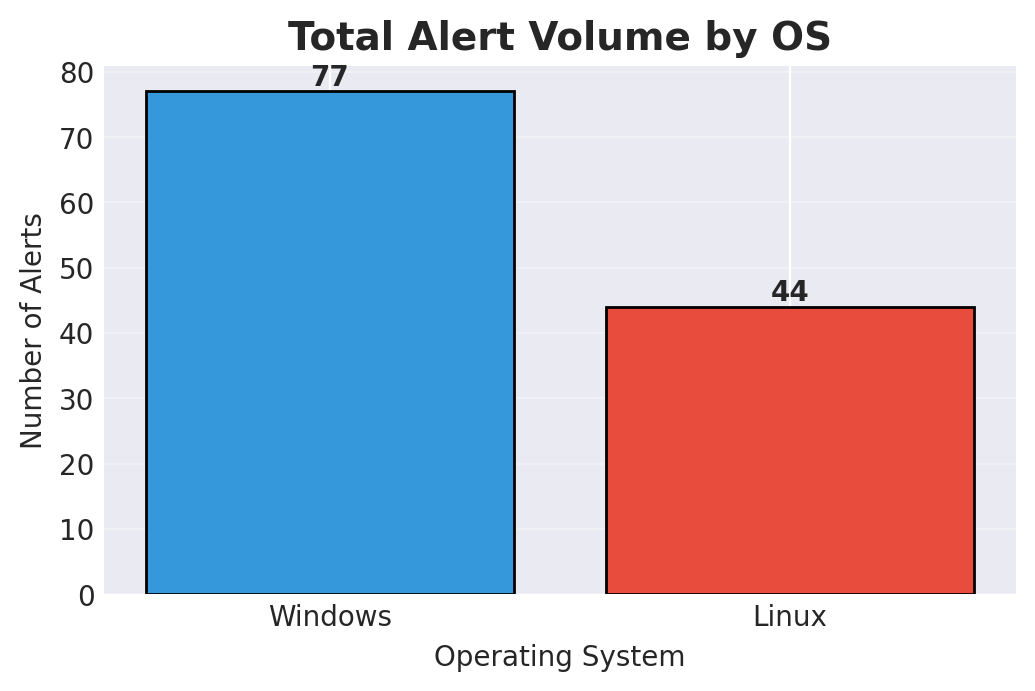

In [9]:
###==============================================================================
## GENERATING COMPREHENSIVE VISUALIZATIONS
###=============================================================================

# ============================================
# 4. VISUALIZATION SUITE
# ============================================

print("\n" + "=" * 80)
print("GENERATING COMPREHENSIVE VISUALIZATIONS")
print("=" * 80)

# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# --- Plot 1: Alert Volume Comparison ---
ax1 = plt.subplot(6, 3, 1)
os_counts = df['os_type'].value_counts()
colors = ['#3498db', '#e74c3c']
bars = ax1.bar(os_counts.index, os_counts.values, color=colors, edgecolor='black')

ax1.set_title('Total Alert Volume by OS', fontsize=14, fontweight='bold')
ax1.set_xlabel('Operating System')
ax1.set_ylabel('Number of Alerts')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for rect in bars:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontweight='bold')


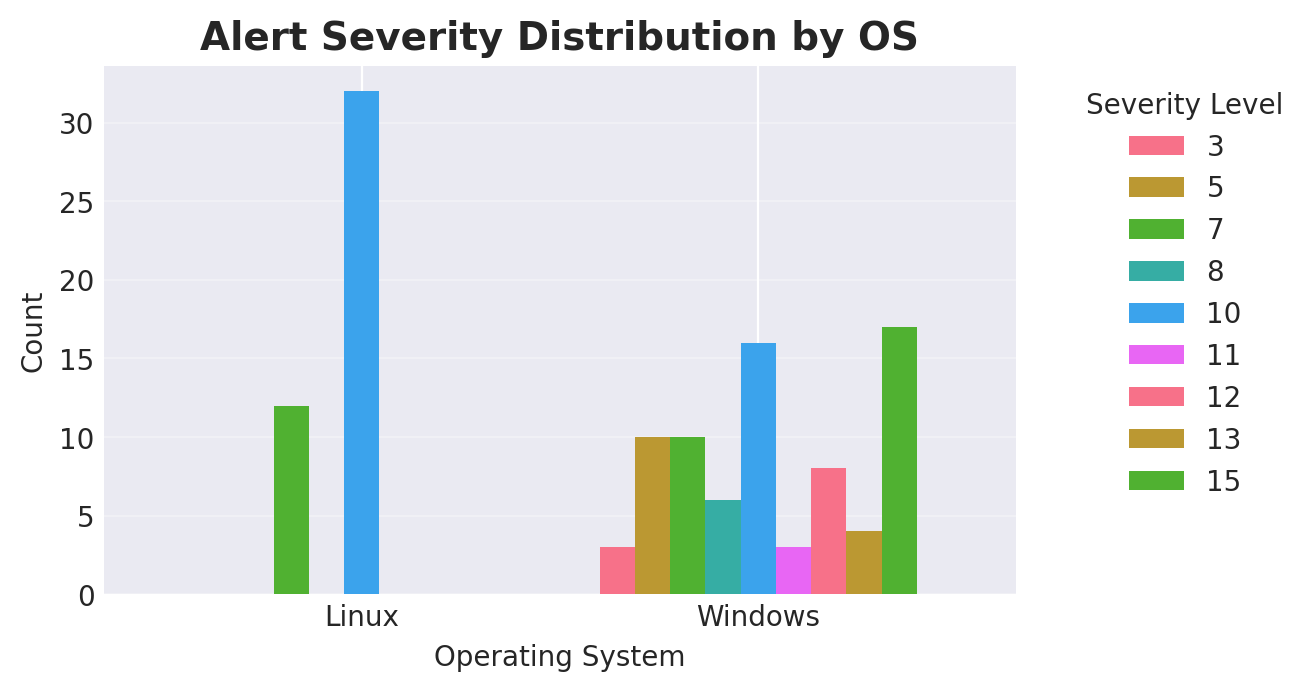

In [10]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# --- Plot 2: Severity Distribution Comparison ---
ax2 = plt.subplot(6, 3, 2)
severity_data = df.groupby(['os_type', 'rule.level']).size().unstack(fill_value=0)
severity_data.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('Alert Severity Distribution by OS', fontsize=14, fontweight='bold')
ax2.set_xlabel('Operating System')
ax2.set_ylabel('Count')
ax2.legend(title='Severity Level', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.grid(axis='y', alpha=0.3)

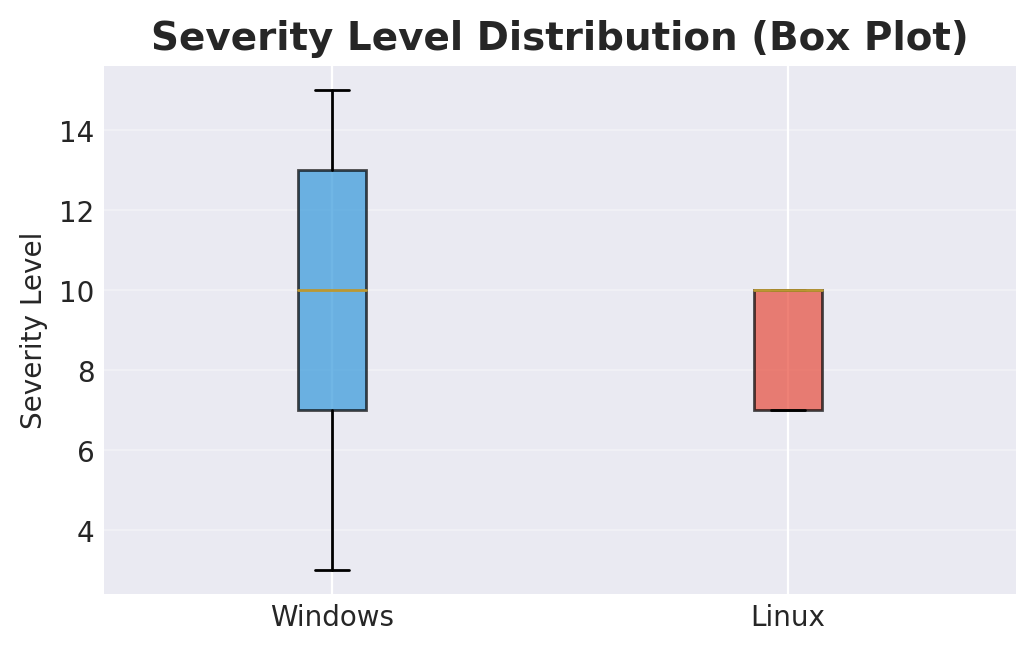

In [11]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# --- Plot 3: Severity Level Box Plot ---
ax3 = plt.subplot(6, 3, 3)
box_data = [windows_df['rule.level'].dropna(), linux_df['rule.level'].dropna()]
bp = ax3.boxplot(box_data, labels=['Windows', 'Linux'], patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.set_title('Severity Level Distribution (Box Plot)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Severity Level')
ax3.grid(axis='y', alpha=0.3)

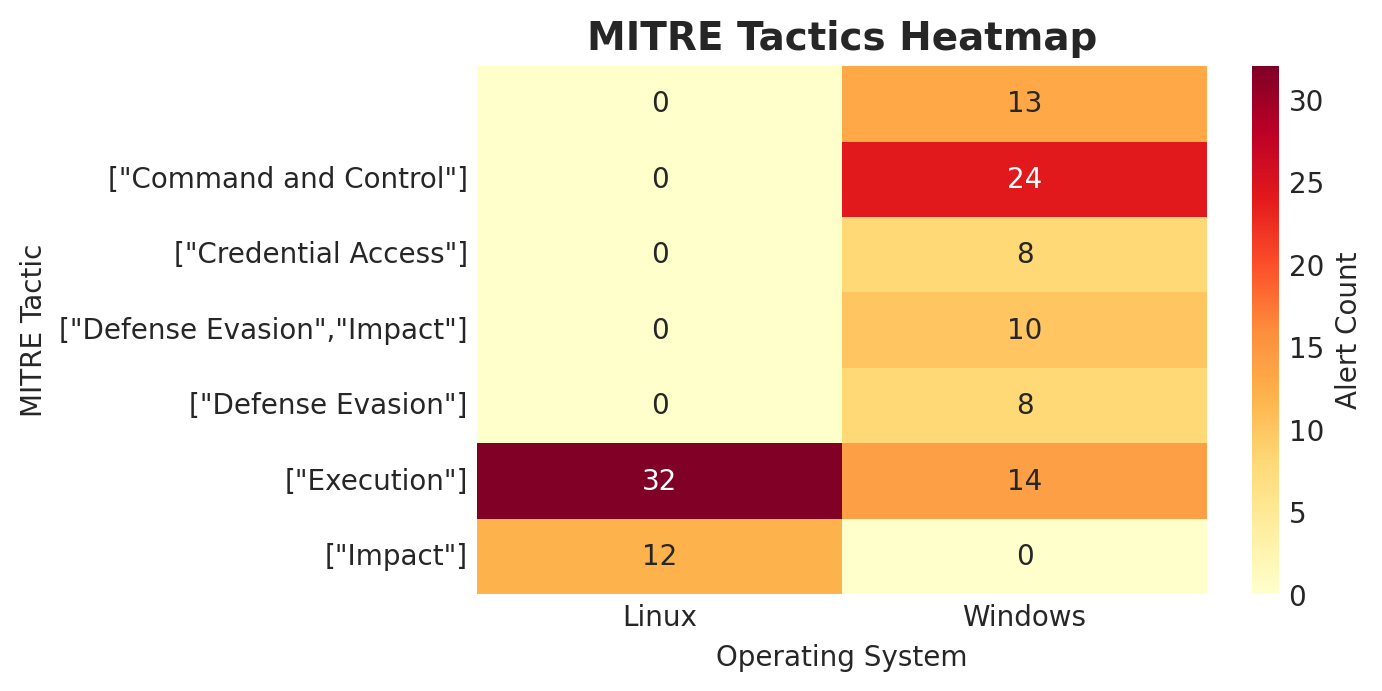

In [12]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# --- Plot 4: MITRE Tactics Heatmap ---
ax4 = plt.subplot(6, 3, 4)
tactics_pivot = df.pivot_table(values='rule.level',
                               index='rule.mitre.tactic',
                               columns='os_type',
                               aggfunc='count',
                               fill_value=0)
if not tactics_pivot.empty:
    sns.heatmap(
        tactics_pivot, 
        annot=True, 
        fmt='d', 
        cmap='YlOrRd', 
        ax=ax4, 
        cbar_kws={'label': 'Alert Count'}
    )
    ax4.set_title('MITRE Tactics Heatmap', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Operating System')
    ax4.set_ylabel('MITRE Tactic')

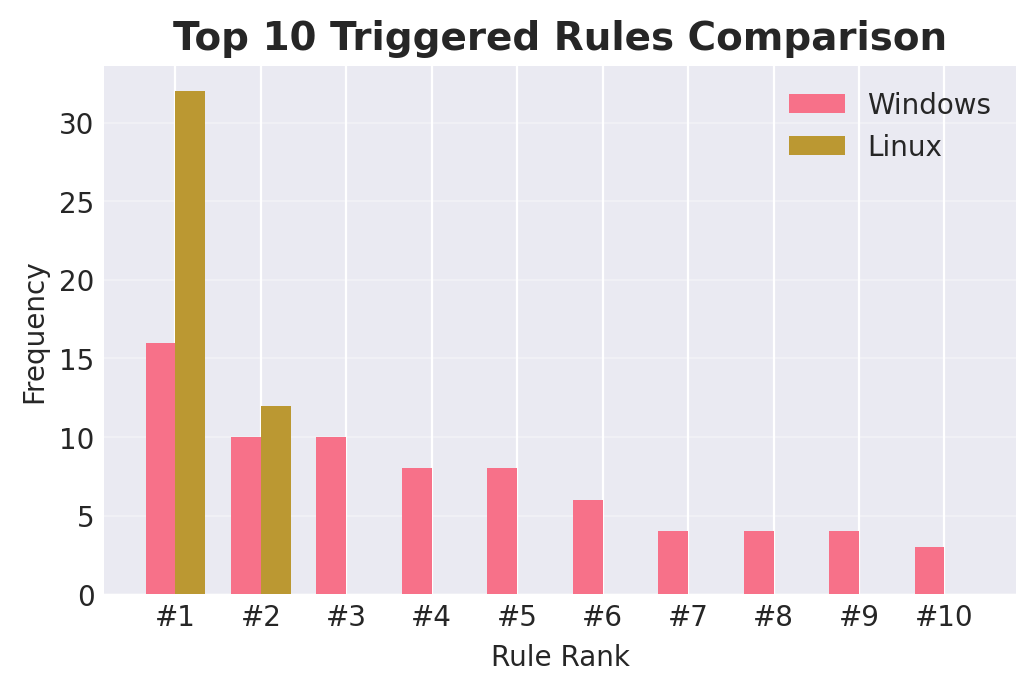

In [13]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# --- Plot 5: Top Rules by OS ---
ax5 = plt.subplot(6, 3, 5)
top_rules_win = windows_df['rule.id'].value_counts().head(10)
top_rules_linux = linux_df['rule.id'].value_counts().head(10)
x = np.arange(10)
width = 0.35
ax5.bar(
    x - width/2, 
    top_rules_win.values[:10] if len(top_rules_win) >= 10 else list(top_rules_win.values) + [0]*(10-len(top_rules_win)), width, 
    label='Windows'
)
ax5.bar(x + width/2, 
        top_rules_linux.values[:10] if len(top_rules_linux) >= 10 else list(top_rules_linux.values) + [0]*(10-len(top_rules_linux)), width, 
        label= 'Linux'
       )
ax5.set_title('Top 10 Triggered Rules Comparison', fontsize=14, fontweight='bold')
ax5.set_xlabel('Rule Rank')
ax5.set_ylabel('Frequency')
ax5.set_xticks(x)
ax5.set_xticklabels([f'#{i+1}' for i in range(10)])
ax5.legend()
ax5.grid(axis='y', alpha=0.3)   

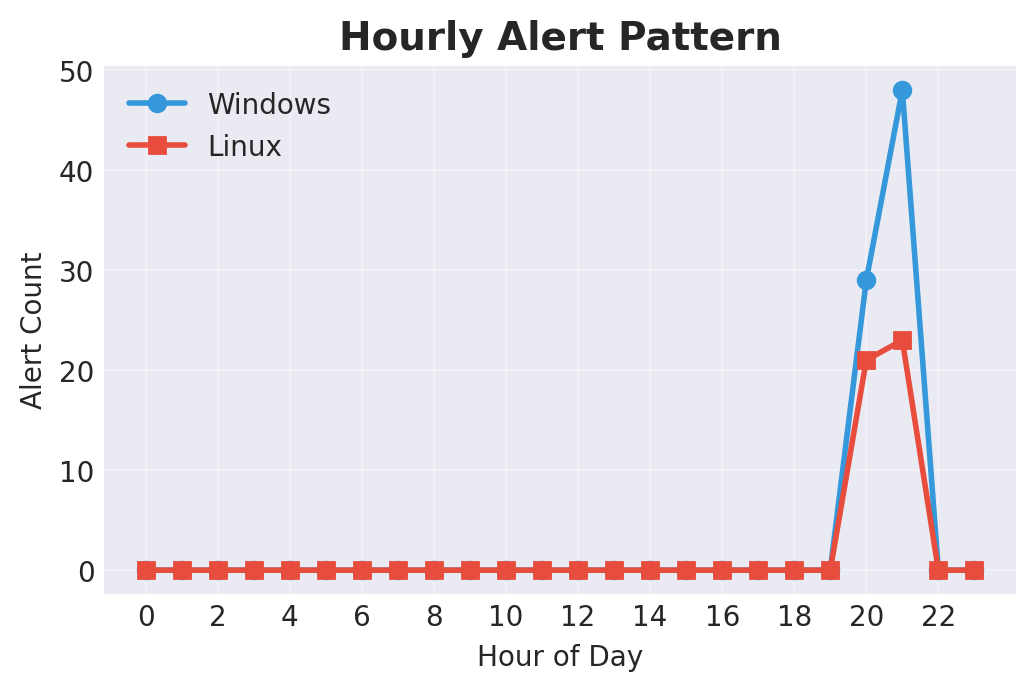

In [14]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# --- Plot 6: Temporal Pattern (Hourly) ---
ax6 = plt.subplot(6, 3, 6)
hourly_windows = windows_df.groupby('hour').size()
hourly_linux = linux_df.groupby('hour').size()
hours = range(24)
ax6.plot(hours, [hourly_windows.get(h, 0) for h in hours],
         marker='o', label='Windows', color='#3498db', linewidth=2),
ax6.plot(hours, [hourly_linux.get(h, 0) for h in hours],
         marker='s', label='Linux', color='#e74c3c', linewidth=2)
ax6.set_title('Hourly Alert Pattern', fontsize=14, fontweight='bold')
ax6.set_xlabel('Hour of Day')
ax6.set_ylabel('Alert Count')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.set_xticks(range(0, 24, 2))                               

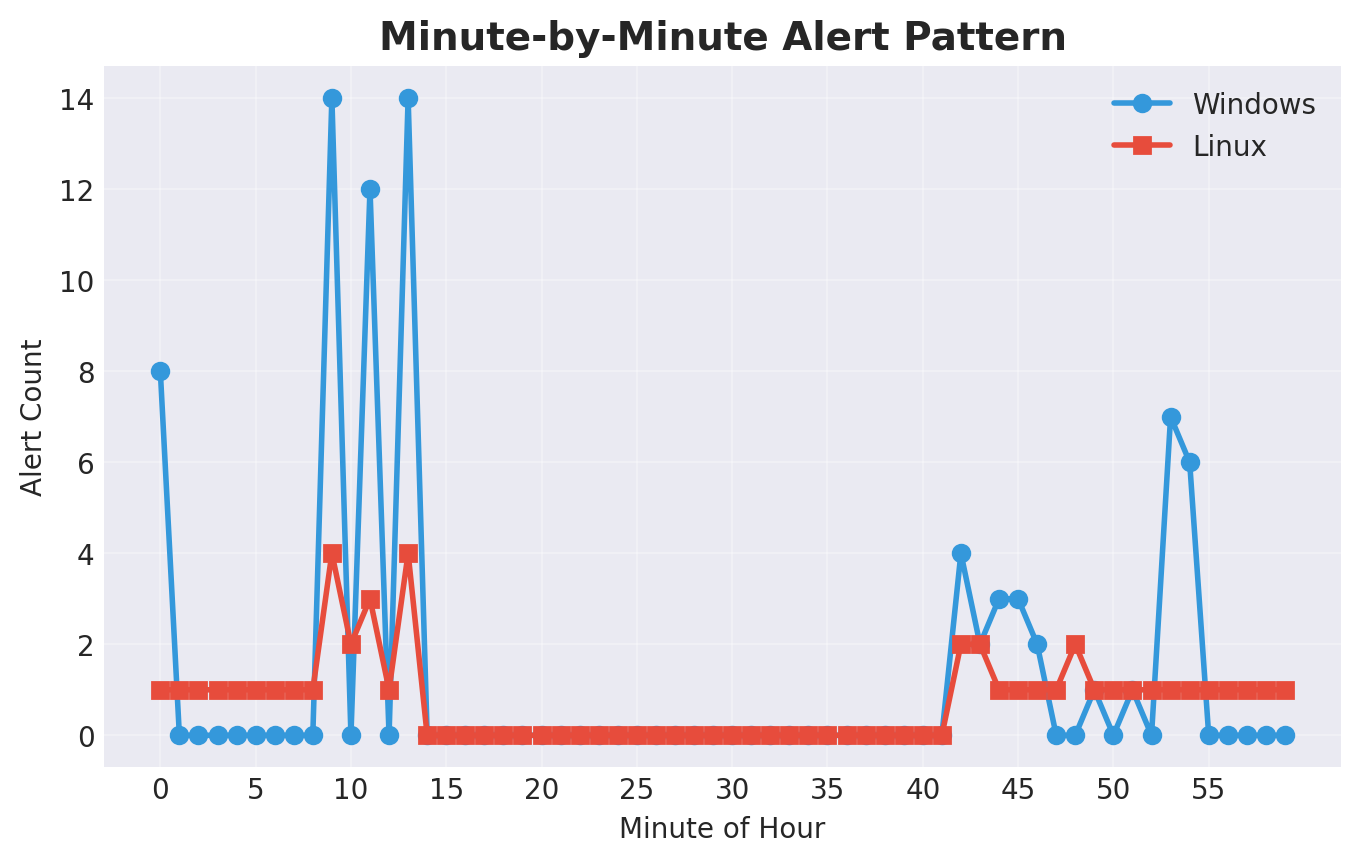

In [15]:
# --- Plot 6: Temporal Pattern (Minute-by-Minute) ---
import matplotlib.pyplot as plt
import pandas as pd

fig = plt.figure(figsize=(20, 24))
ax6 = plt.subplot(6, 3, 6)

# --- Ensure there's a parsed datetime column ---
time_col = "timestamp" if "timestamp" in df.columns else "_parsed_time"

# Extract minute-of-hour feature (0–59)
windows_df["minute"] = pd.to_datetime(windows_df[time_col], errors="coerce").dt.minute
linux_df["minute"]   = pd.to_datetime(linux_df[time_col], errors="coerce").dt.minute

# Group by minute and count
minute_windows = windows_df.groupby("minute").size()
minute_linux   = linux_df.groupby("minute").size()

minutes = range(60)
ax6.plot(minutes, [minute_windows.get(m, 0) for m in minutes],
         marker="o", label="Windows", color="#3498db", linewidth=2)
ax6.plot(minutes, [minute_linux.get(m, 0) for m in minutes],
         marker="s", label="Linux", color="#e74c3c", linewidth=2)

ax6.set_title("Minute-by-Minute Alert Pattern", fontsize=14, fontweight="bold")
ax6.set_xlabel("Minute of Hour")
ax6.set_ylabel("Alert Count")
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.set_xticks(range(0, 60, 5))  # tick every 5 minutes for readability

plt.tight_layout()
plt.show()


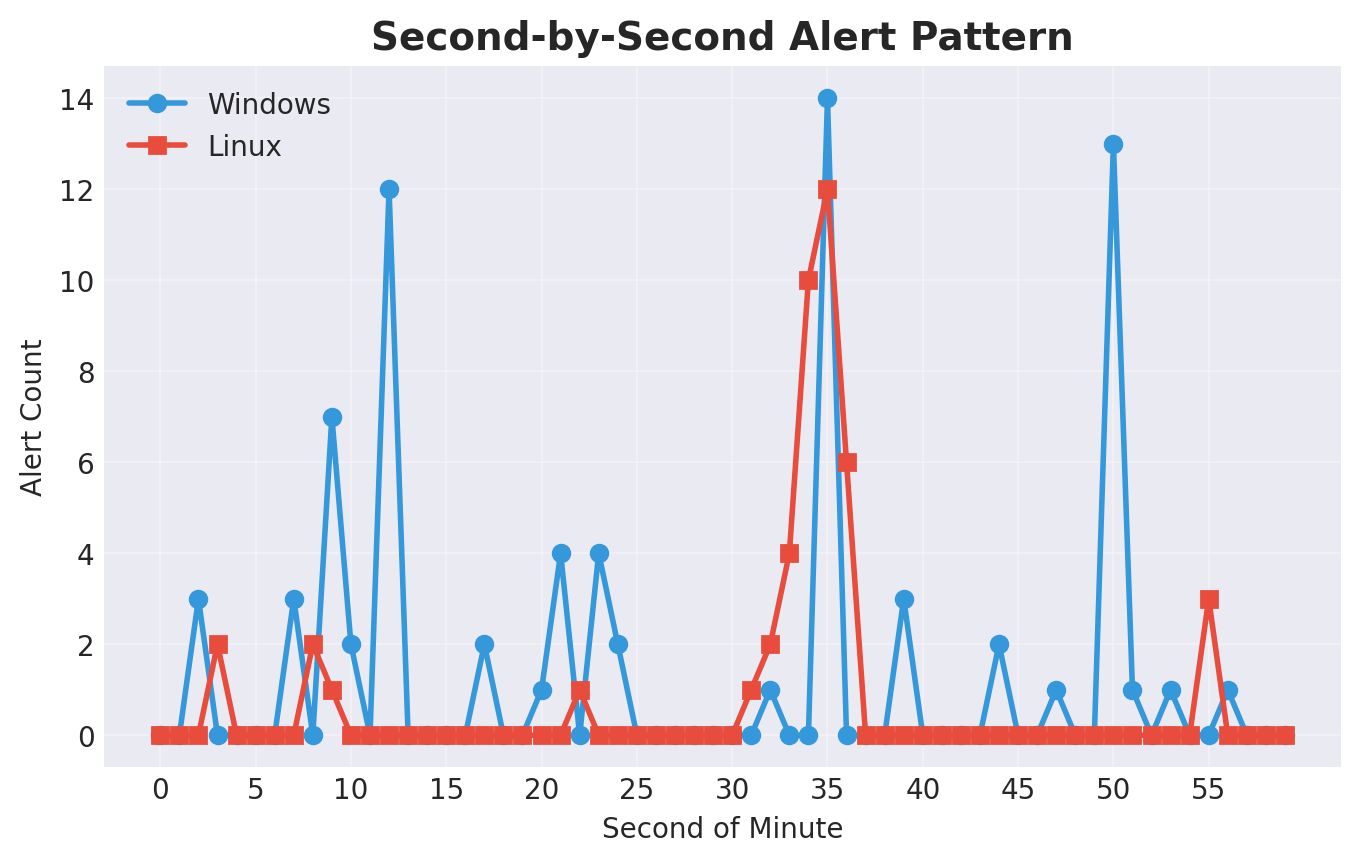

In [16]:
# --- Plot 6: Temporal Pattern (Second-by-Second) ---
import matplotlib.pyplot as plt
import pandas as pd

fig = plt.figure(figsize=(20, 24))
ax6 = plt.subplot(6, 3, 6)

# --- Ensure there's a parsed datetime column ---
time_col = "timestamp" if "timestamp" in df.columns else "_parsed_time"

# Extract second-of-minute feature (0–59)
windows_df["second"] = pd.to_datetime(windows_df[time_col], errors="coerce").dt.second
linux_df["second"]   = pd.to_datetime(linux_df[time_col], errors="coerce").dt.second

# Group by second and count
second_windows = windows_df.groupby("second").size()
second_linux   = linux_df.groupby("second").size()

seconds = range(60)
ax6.plot(seconds, [second_windows.get(s, 0) for s in seconds],
         marker="o", label="Windows", color="#3498db", linewidth=2)
ax6.plot(seconds, [second_linux.get(s, 0) for s in seconds],
         marker="s", label="Linux", color="#e74c3c", linewidth=2)

ax6.set_title("Second-by-Second Alert Pattern", fontsize=14, fontweight="bold")
ax6.set_xlabel("Second of Minute")
ax6.set_ylabel("Alert Count")
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.set_xticks(range(0, 60, 5))  # tick every 5 seconds for readability

plt.tight_layout()
plt.show()


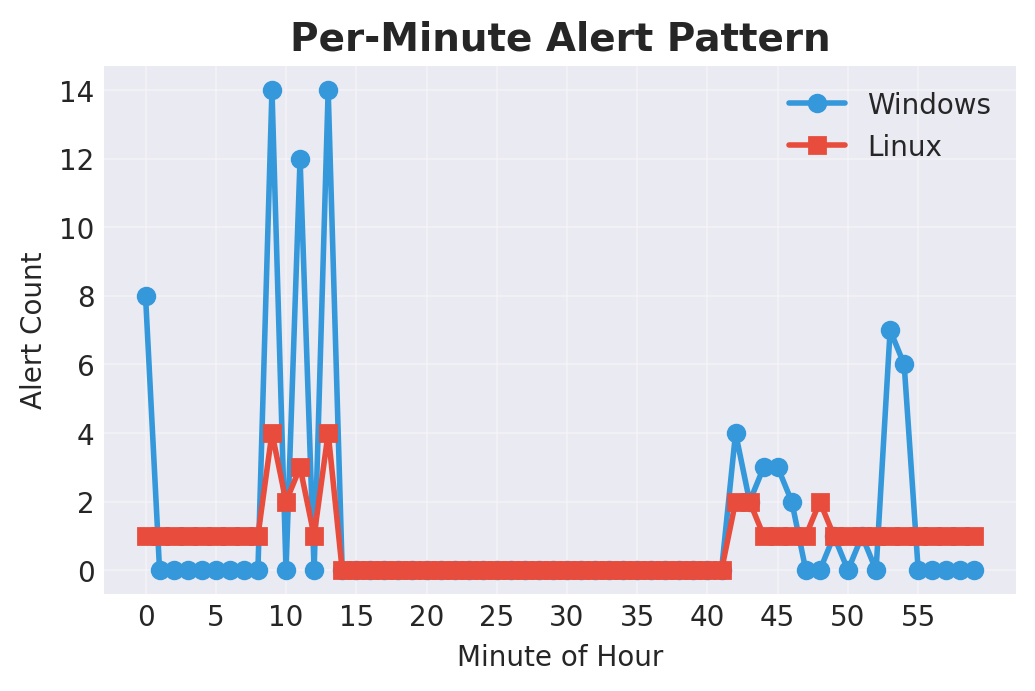

In [17]:
# Detect and parse a timestamp column
# Replace with the actual column name if you know it (e.g., 'EventTime', 'timestamp', 'date')
TIME_COL = None  

# Try common timestamp column names
for col in ['EventTime', '_time', 'timestamp', 'date']:
    if col in windows_df.columns:
        TIME_COL = col
        break

if TIME_COL:
    # Parse datetime
    windows_df['_parsed_time'] = pd.to_datetime(windows_df[TIME_COL], errors='coerce', utc=True)
    linux_df['_parsed_time'] = pd.to_datetime(linux_df[TIME_COL], errors='coerce', utc=True)

    # Extract minute
    windows_df['minute'] = windows_df['_parsed_time'].dt.minute
    linux_df['minute'] = linux_df['_parsed_time'].dt.minute

    # Group by minute
    minute_windows = windows_df.groupby('minute').size()
    minute_linux = linux_df.groupby('minute').size()
    minutes = range(60)

    # Plot
    fig = plt.figure(figsize=(20, 24))
    ax6 = plt.subplot(6, 3, 6)

    ax6.plot(minutes, [minute_windows.get(m, 0) for m in minutes],
             marker='o', label='Windows', color='#3498db', linewidth=2)
    ax6.plot(minutes, [minute_linux.get(m, 0) for m in minutes],
             marker='s', label='Linux', color='#e74c3c', linewidth=2)

    ax6.set_title('Per-Minute Alert Pattern', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Minute of Hour')
    ax6.set_ylabel('Alert Count')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    ax6.set_xticks(range(0, 60, 5))
else:
    print("⚠️ No timestamp column found. Please tell me which column in your data is the datetime.")


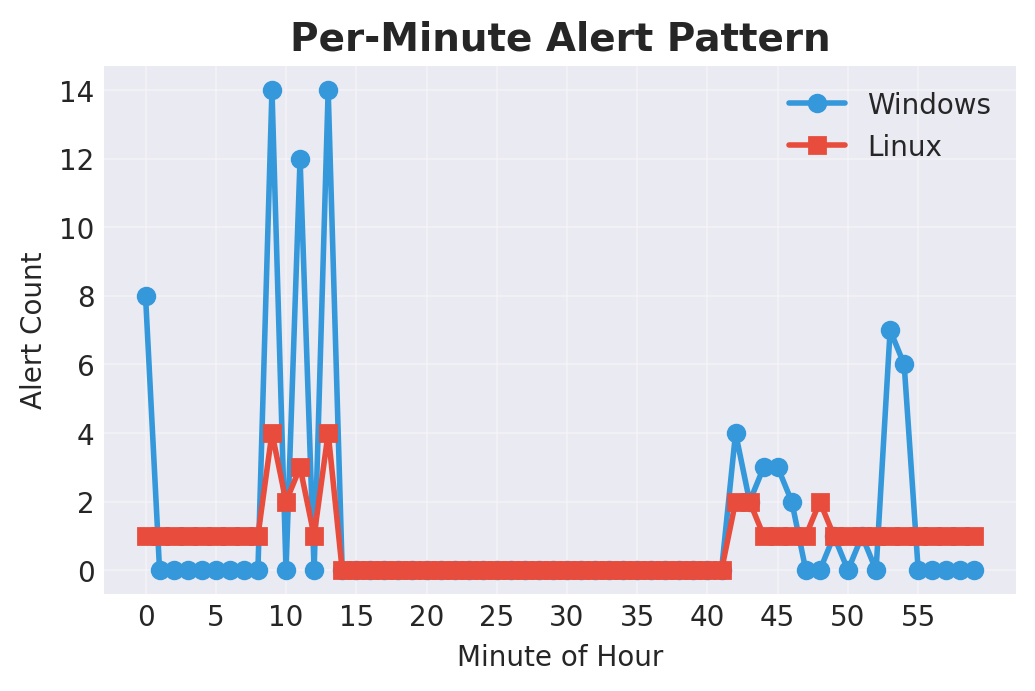

In [18]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# --- Plot 6: Temporal Pattern (Minute) ---
ax6 = plt.subplot(6, 3, 6)

# Extract minute from datetime
windows_df['minute'] = windows_df['_parsed_time'].dt.minute
linux_df['minute'] = linux_df['_parsed_time'].dt.minute

# Group by minute (0–59)
minute_windows = windows_df.groupby('minute').size()
minute_linux = linux_df.groupby('minute').size()
minutes = range(60)

# Plot
ax6.plot(minutes, [minute_windows.get(m, 0) for m in minutes],
         marker='o', label='Windows', color='#3498db', linewidth=2)
ax6.plot(minutes, [minute_linux.get(m, 0) for m in minutes],
         marker='s', label='Linux', color='#e74c3c', linewidth=2)

ax6.set_title('Per-Minute Alert Pattern', fontsize=14, fontweight='bold')
ax6.set_xlabel('Minute of Hour')
ax6.set_ylabel('Alert Count')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.set_xticks(range(0, 60, 5))  # show ticks every 5 minutes


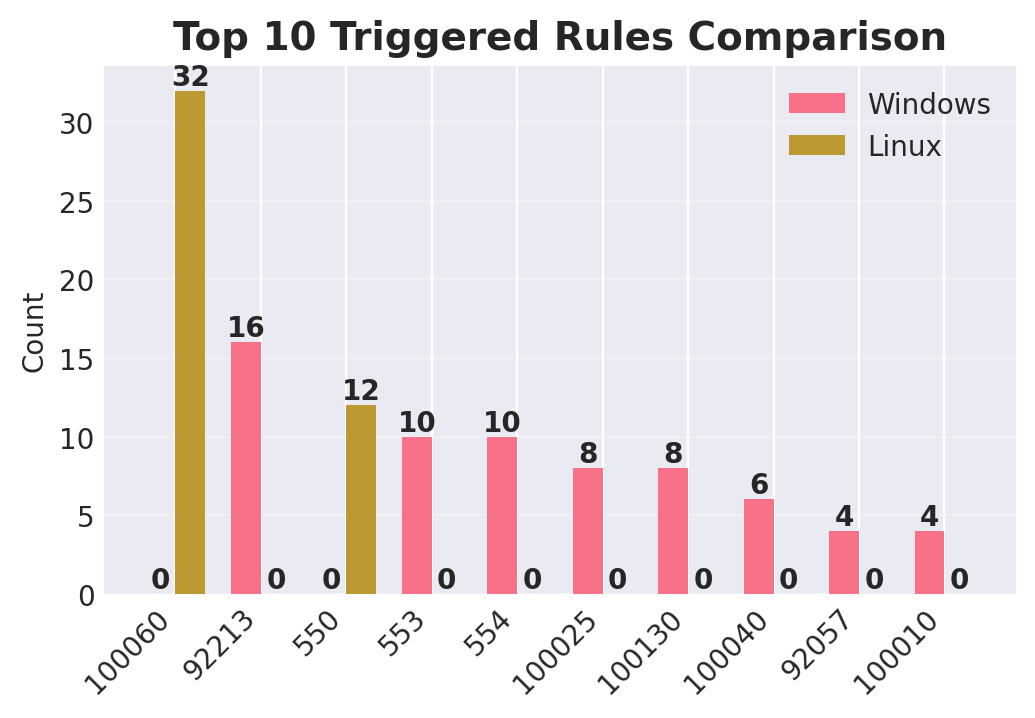

In [19]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# --- Plot 7: Top 10 Triggered Rules Comparison (Windows vs Linux) ---
ax7 = plt.subplot(6, 3, 7)

# Ensure we have Series (handles dict-like inputs too)
win_series = pd.Series(top_rules_win).sort_values(ascending=False)
lin_series = pd.Series(top_rules_linux).sort_values(ascending=False)

# Build a common top-K category list using combined frequency
k = 10
combined = (win_series.add(lin_series, fill_value=0)).sort_values(ascending=False)
cats = list(combined.head(k).index)

# Heights aligned to the same category order
win_vals = [float(win_series.get(c, 0)) for c in cats]
lin_vals = [float(lin_series.get(c, 0)) for c in cats]

# X positions
import numpy as np
x = np.arange(len(cats))
width = 0.35

# Bars
bars_win = ax7.bar(x - width/2, win_vals, width, label='Windows')
bars_lin = ax7.bar(x + width/2, lin_vals, width, label='Linux')

# Annotate bars helper
def annotate_bars(ax, containers):
    if not isinstance(containers, (list, tuple)):
        containers = [containers]
    for container in containers:
        for rect in container:  # each is a Rectangle
            h = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2.0,
                    h,
                    f'{int(h)}',
                    ha='center', va='bottom', fontweight='bold')

annotate_bars(ax7, [bars_win, bars_lin])

# Formatting
ax7.set_title('Top 10 Triggered Rules Comparison', fontsize=14, fontweight='bold')
ax7.set_xticks(x)
ax7.set_xticklabels(cats, rotation=45, ha='right')
ax7.set_ylabel('Count')
ax7.grid(axis='y', alpha=0.3)
ax7.legend()


(None,)

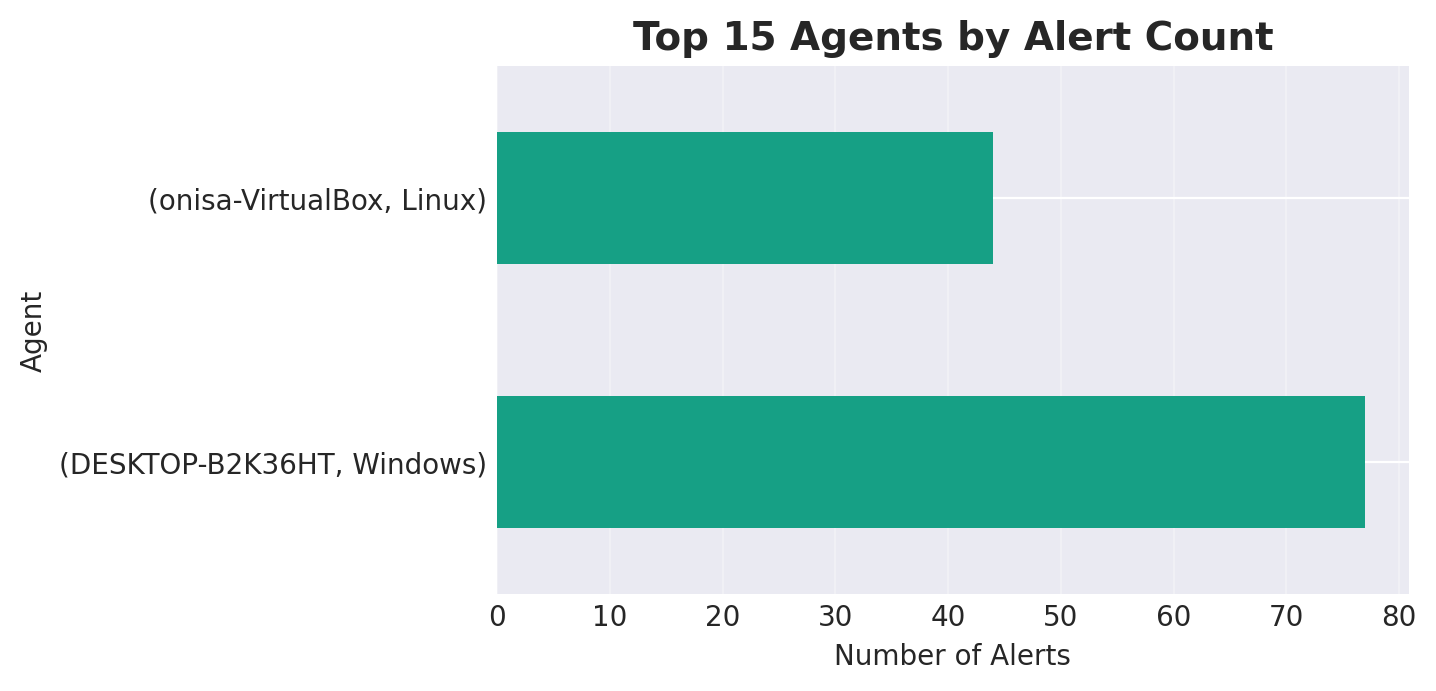

In [20]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# --- Plot 8: Agent Alert Distribution ---
ax8 = plt.subplot(6, 3, 8)
agent_alerts = df.groupby(['agent.name', 'os_type']).size().sort_values(ascending=False)
agent_alerts.plot(kind='barh', ax=ax8, color='#16a085'),
ax8.set_title('Top 15 Agents by Alert Count', fontsize=14, fontweight='bold'),
ax8.set_xlabel('Number of Alerts'),
ax8.set_ylabel('Agent'),
ax8.grid(axis='x', alpha=0.3),
                                   

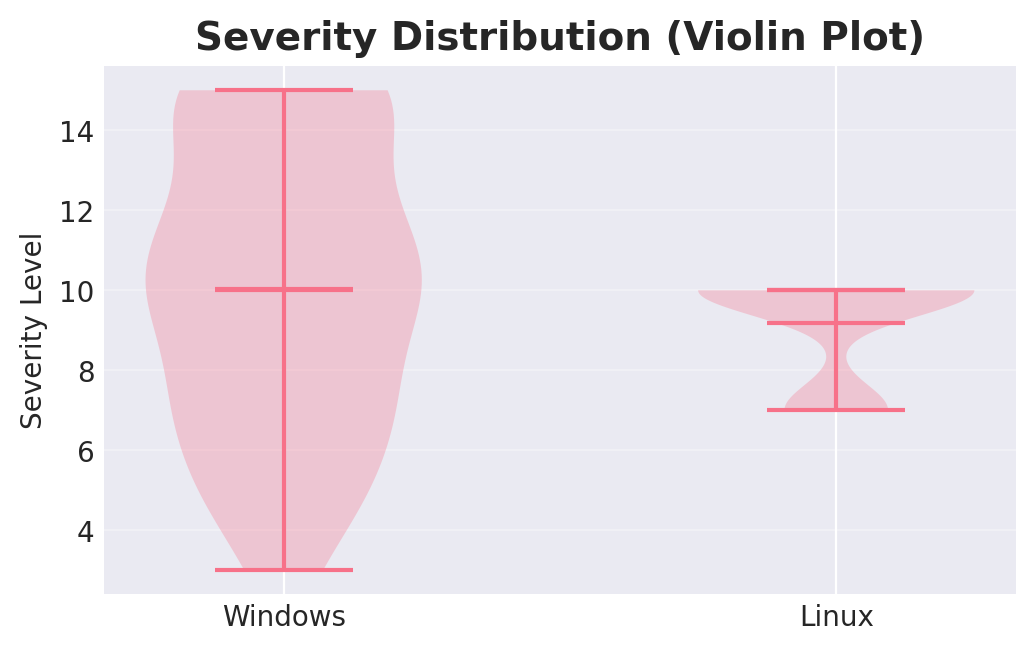

In [21]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# --- Plot 9: Rule Level Violin Plot ---
ax9 = plt.subplot(6, 3, 9)
violin_data = df[['os_type', 'rule.level']].dropna()
                                                            
if not violin_data.empty:
    parts = ax9.violinplot(
        [windows_df['rule.level'].dropna(), linux_df['rule.level'].dropna()],
        positions=[1, 2], 
        showmeans=True, 
        showmedians=True
    )
    ax9.set_xticks([1, 2])
    ax9.set_xticklabels(['Windows', 'Linux'])
    ax9.set_title('Severity Distribution (Violin Plot)', fontsize=14, fontweight='bold')
    ax9.set_ylabel('Severity Level')
    ax9.grid(axis='y', alpha=0.3)

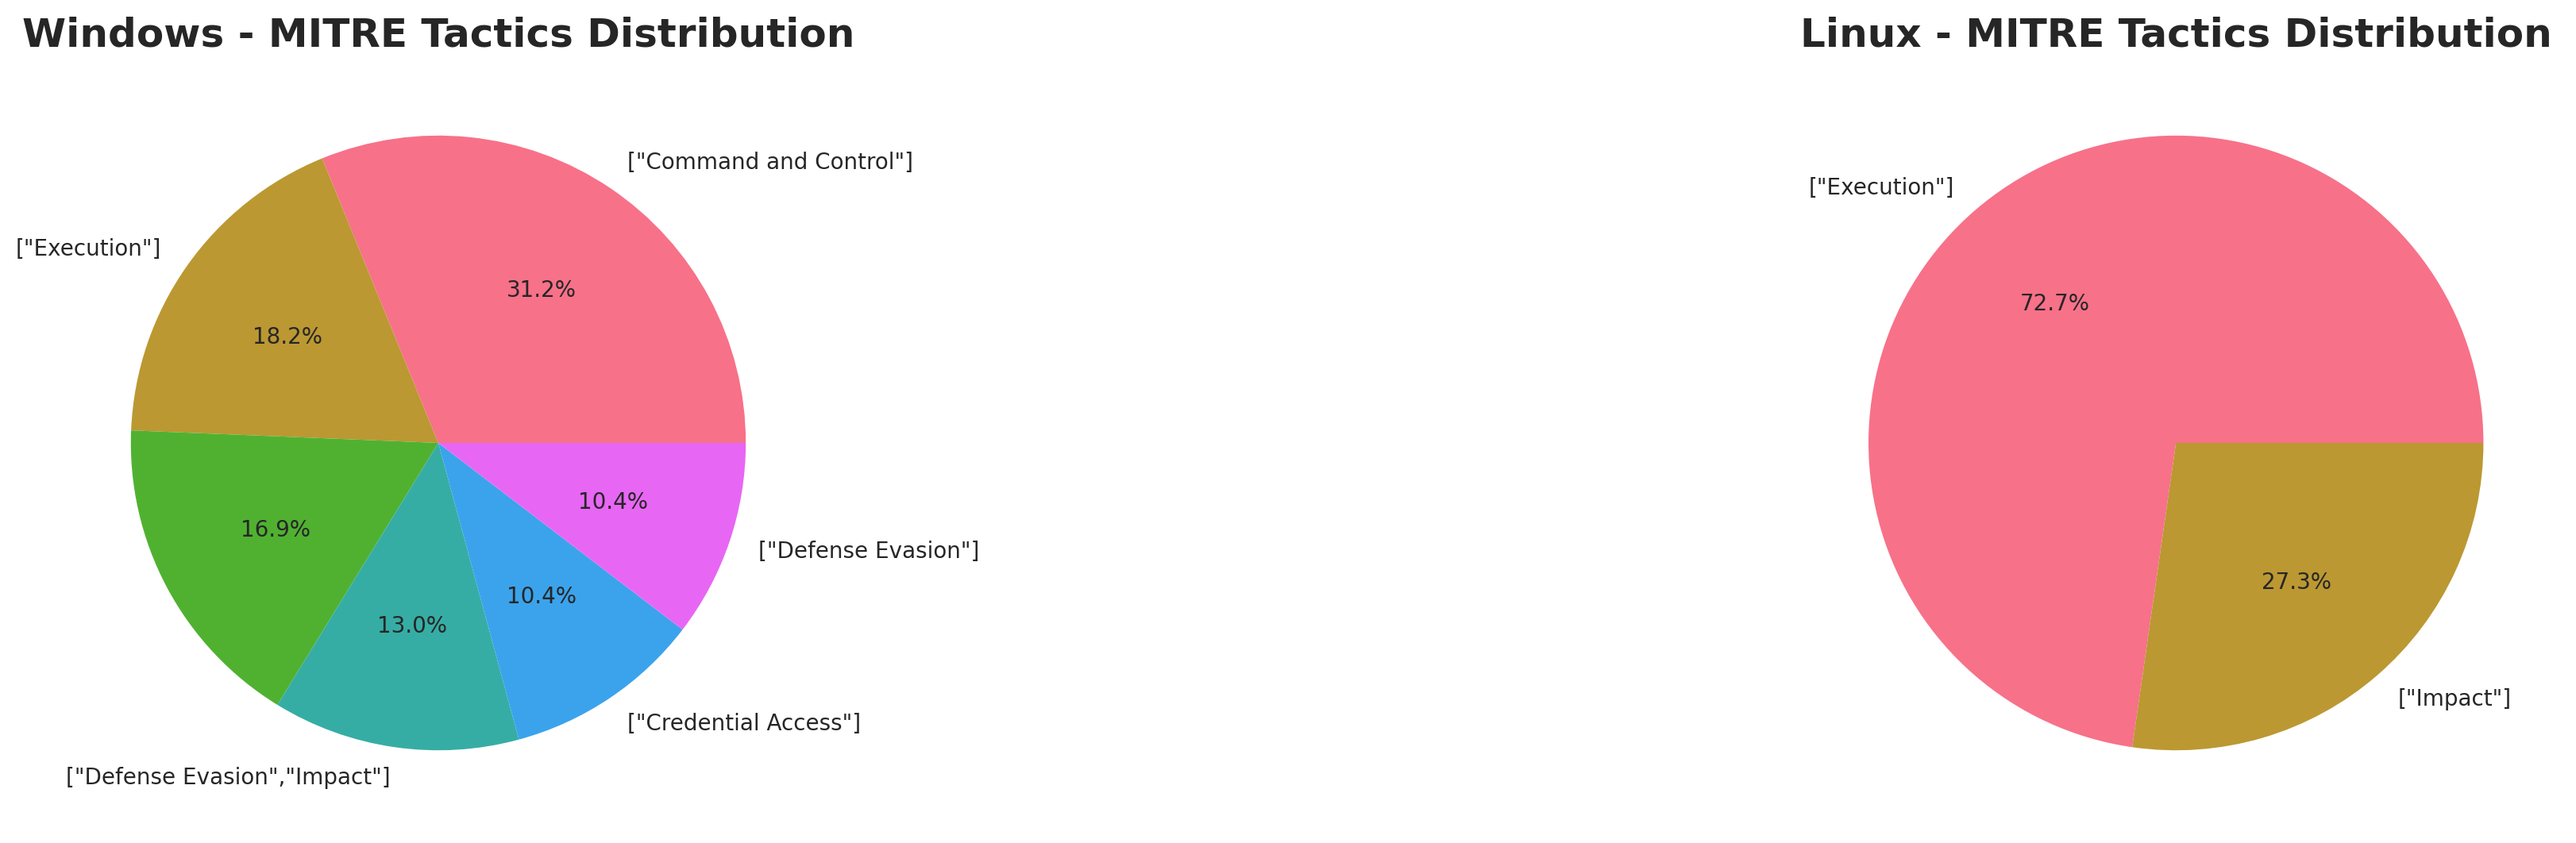

In [22]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(40, 44))

# --- Plot 10: MITRE Tactics Pie Charts ---
ax10 = plt.subplot(6, 3, 10)
windows_tactics = windows_df['rule.mitre.tactic'].value_counts()
if not windows_tactics.empty:
    ax10.pie(
        windows_tactics.values, 
        labels=windows_tactics.index, 
        autopct='%1.1f%%'
    )
    ax10.set_title('Windows - MITRE Tactics Distribution', fontsize=18, fontweight='bold')
ax11 = plt.subplot(6, 3, 11)
linux_tactics = linux_df['rule.mitre.tactic'].value_counts()
if not linux_tactics.empty:
    ax11.pie(
        linux_tactics.values, 
        labels=linux_tactics.index, 
        autopct='%1.1f%%'
    )
    ax11.set_title('Linux - MITRE Tactics Distribution', fontsize=18, fontweight='bold')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

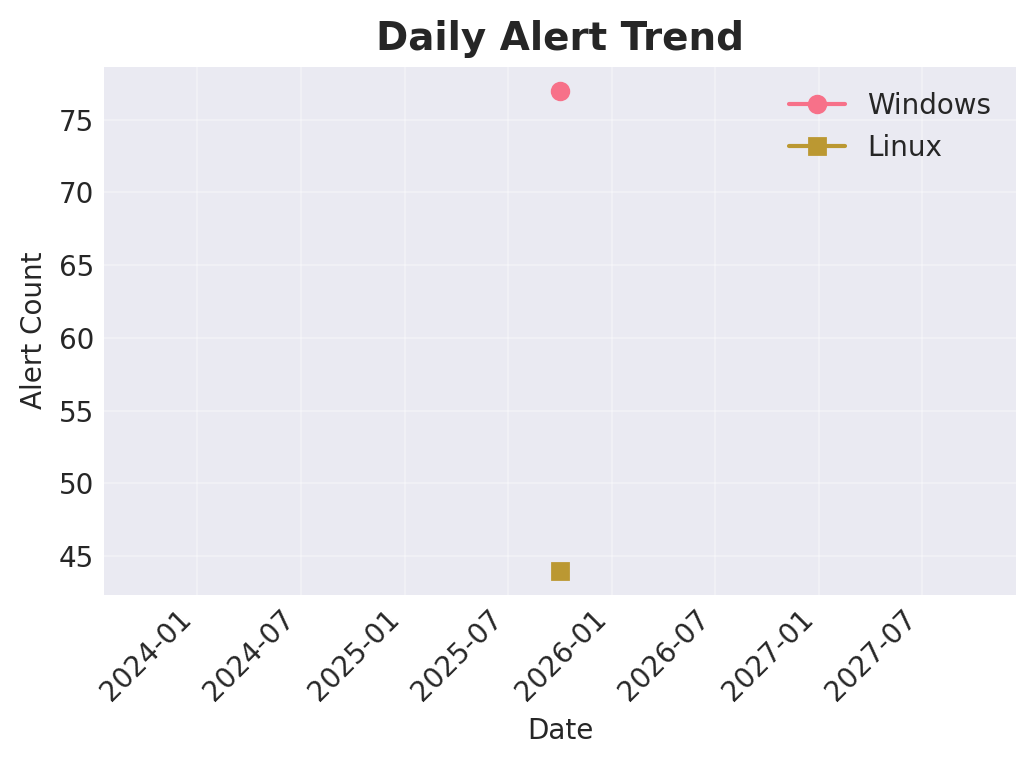

In [23]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# --- Plot 12: Time Series Analysis ---
ax12 = plt.subplot(6, 3, 12)
daily_windows = windows_df.groupby('date').size()
daily_linux = linux_df.groupby('date').size()
if not daily_windows.empty:
    ax12.plot(daily_windows.index, daily_windows.values, marker='o', label='Windows'),
if not daily_linux.empty:
    ax12.plot(daily_linux.index, daily_linux.values, marker='s', label='Linux'), 
ax12.set_title('Daily Alert Trend', fontsize=14, fontweight='bold')
ax12.set_xlabel('Date')
ax12.set_ylabel('Alert Count')
ax12.legend()
ax12.grid(True, alpha=0.3)
plt.setp(ax12.xaxis.get_majorticklabels(), rotation=45, ha='right')


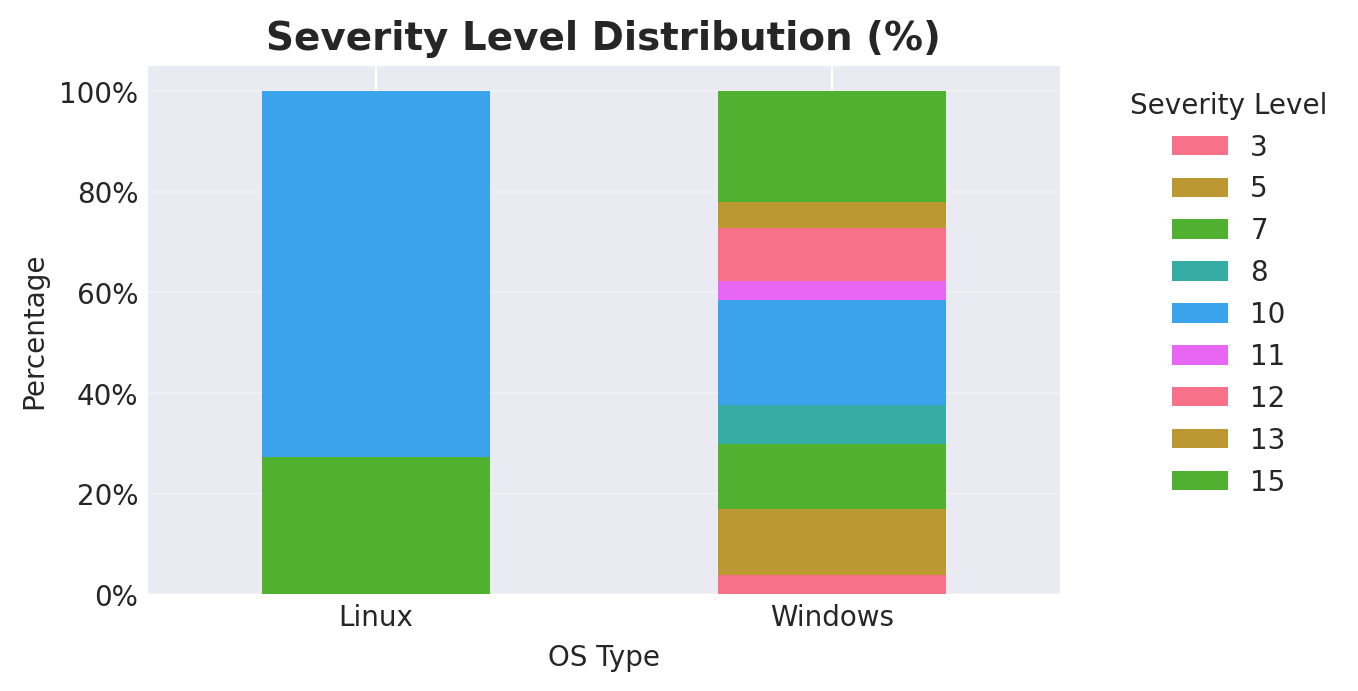

In [24]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# pick the right column name whether it's 'rule.level' or 'rule\.level'
rule_level_col = (
    'rule.level' if 'rule.level' in df.columns
    else ('rule\\.level' if 'rule\\.level' in df.columns else None)
)
if rule_level_col is None:
    raise KeyError("Neither 'rule.level' nor 'rule\\.level' found in df.columns")

# --- Plot 13: Severity Percentage Stacked Bar ---
ax13 = plt.subplot(6, 3, 13)

severity_pct = (
    df.groupby(['os_type', rule_level_col])
      .size()
      .groupby(level=0)
      .apply(lambda s: 100 * s / s.sum())
      .unstack(fill_value=0)
)

severity_pct.plot(kind='bar', stacked=True, ax=ax13)
ax13.set_title('Severity Level Distribution (%)', fontsize=14, fontweight='bold')
ax13.set_xlabel('OS Type')
ax13.set_ylabel('Percentage')
ax13.legend(title='Severity Level', bbox_to_anchor=(1.05, 1), loc='upper left')
ax13.set_xticklabels(ax13.get_xticklabels(), rotation=0)
ax13.grid(axis='y', alpha=0.3)

from matplotlib.ticker import PercentFormatter
ax13.yaxis.set_major_formatter(PercentFormatter(100))


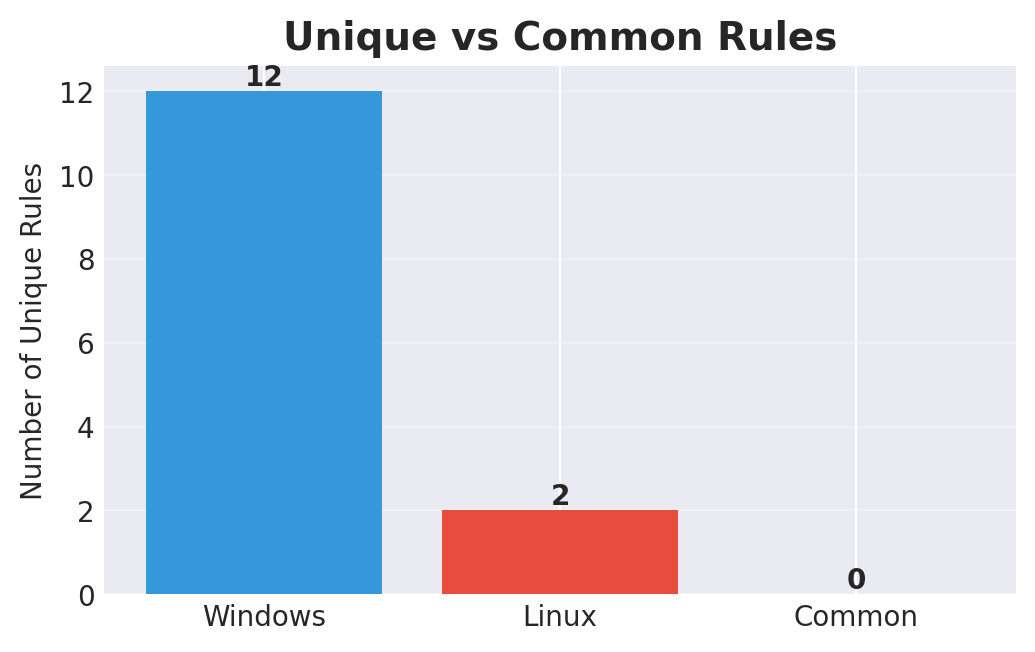

In [25]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# --- Plot 14: Unique Rules per OS ---
ax14 = plt.subplot(6, 3, 14)
unique_rules = pd.Series({
    'Windows': windows_df['rule.id'].nunique(),
    'Linux': linux_df['rule.id'].nunique(),
    'Common': len(set(windows_df['rule.id']) & set(linux_df['rule.id']))
})
bars = ax14.bar(unique_rules.index, unique_rules.values, color=['#3498db', '#e74c3c'])
ax14.set_title('Unique vs Common Rules', fontsize=14, fontweight='bold')
ax14.set_ylabel('Number of Unique Rules')
ax14.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax14.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}'
, ha='center', va='bottom', fontweight='bold')

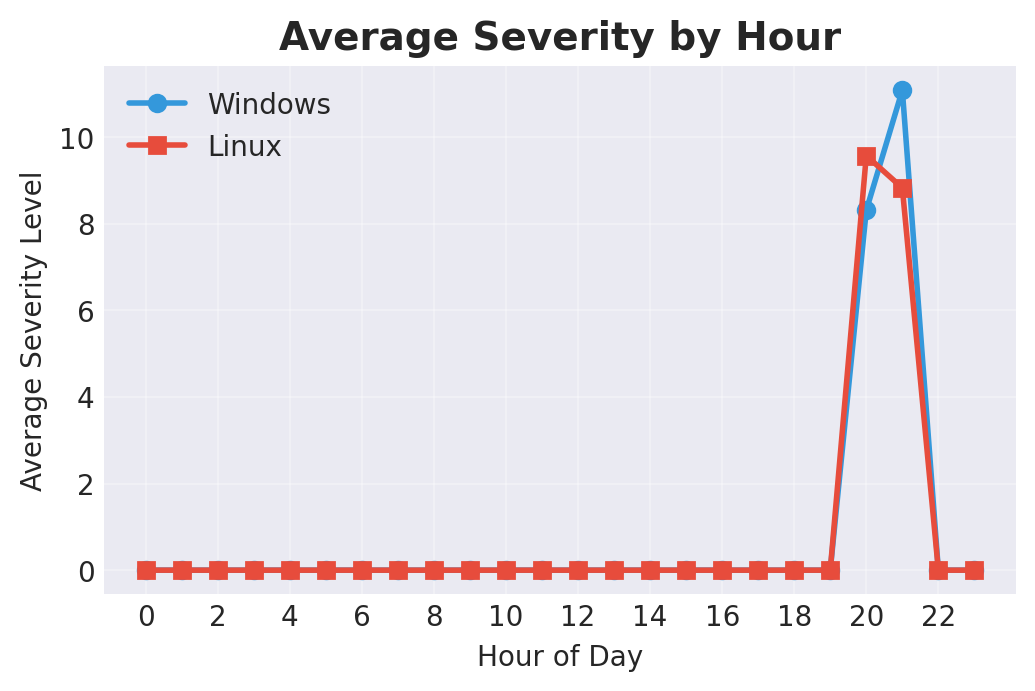

In [26]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# --- Plot 15: Average Severity by Hour ---
ax15 = plt.subplot(6, 3, 15)
hourly_sev_win = windows_df.groupby('hour')['rule.level'].mean()
hourly_sev_linux = linux_df.groupby('hour')['rule.level'].mean()
hours = range(24)
ax15.plot(hours, [hourly_sev_win.get(h, 0) for h in hours],
    marker='o', label='Windows', color='#3498db', linewidth=2)
ax15.plot(hours, [hourly_sev_linux.get(h, 0) for h in hours],
    marker='s', label='Linux', color='#e74c3c', linewidth=2)
ax15.set_title('Average Severity by Hour', fontsize=14, fontweight='bold')
ax15.set_xlabel('Hour of Day')
ax15.set_ylabel('Average Severity Level')
ax15.legend()
ax15.grid(True, alpha=0.3)
ax15.set_xticks(range(0, 24, 2))

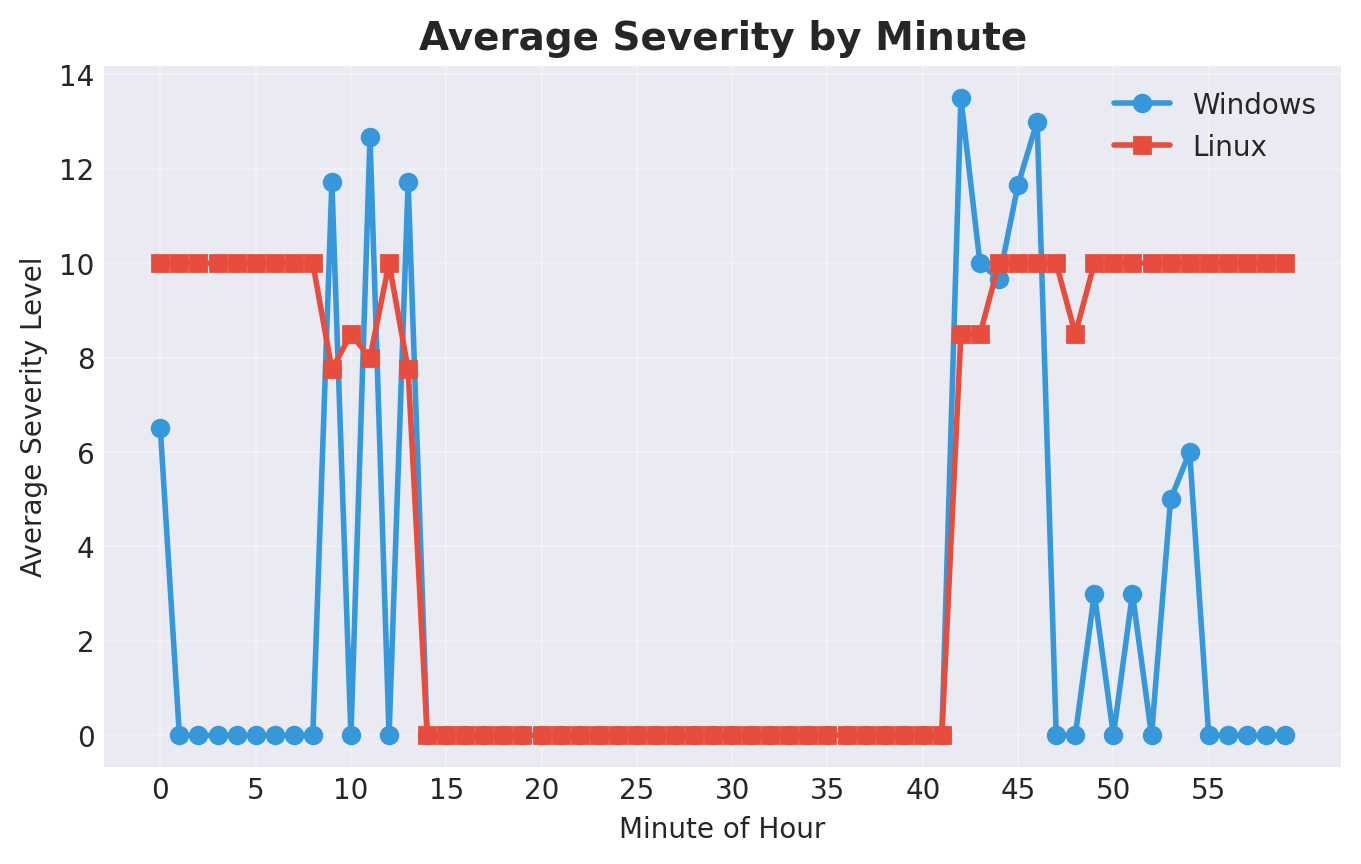

In [27]:
# --- Plot 15: Average Severity by Minute ---
import matplotlib.pyplot as plt
import pandas as pd

fig = plt.figure(figsize=(20, 24))
ax15 = plt.subplot(6, 3, 15)

# --- Ensure you have a datetime column ---
time_col = "timestamp" if "timestamp" in df.columns else "_parsed_time"

# Extract minute of hour (0–59)
windows_df["minute"] = pd.to_datetime(windows_df[time_col], errors="coerce").dt.minute
linux_df["minute"]   = pd.to_datetime(linux_df[time_col], errors="coerce").dt.minute

# Group by minute and calculate average severity
minute_sev_win   = windows_df.groupby("minute")["rule.level"].mean()
minute_sev_linux = linux_df.groupby("minute")["rule.level"].mean()

minutes = range(60)
ax15.plot(minutes, [minute_sev_win.get(m, 0) for m in minutes],
          marker="o", label="Windows", color="#3498db", linewidth=2)
ax15.plot(minutes, [minute_sev_linux.get(m, 0) for m in minutes],
          marker="s", label="Linux", color="#e74c3c", linewidth=2)

ax15.set_title("Average Severity by Minute", fontsize=14, fontweight="bold")
ax15.set_xlabel("Minute of Hour")
ax15.set_ylabel("Average Severity Level")
ax15.legend()
ax15.grid(True, alpha=0.3)
ax15.set_xticks(range(0, 60, 5))  # every 5 minutes

plt.tight_layout()
plt.show()


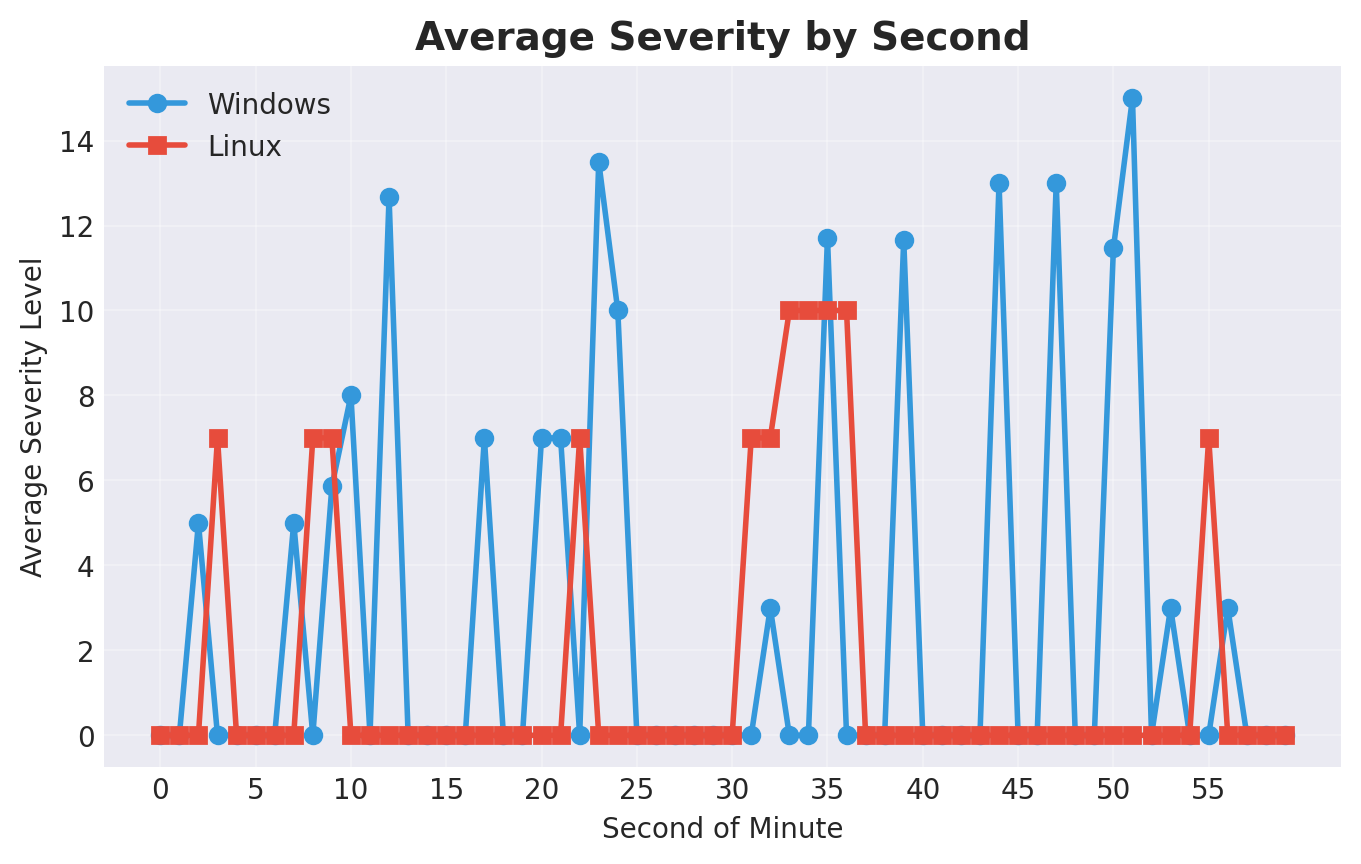

In [28]:
# --- Plot 15: Average Severity by Second ---
import matplotlib.pyplot as plt
import pandas as pd

fig = plt.figure(figsize=(20, 24))
ax15 = plt.subplot(6, 3, 15)

# --- Ensure there’s a parsed datetime column ---
time_col = "timestamp" if "timestamp" in df.columns else "_parsed_time"

# Extract second of minute (0–59)
windows_df["second"] = pd.to_datetime(windows_df[time_col], errors="coerce").dt.second
linux_df["second"]   = pd.to_datetime(linux_df[time_col], errors="coerce").dt.second

# Group by second and compute average severity
second_sev_win   = windows_df.groupby("second")["rule.level"].mean()
second_sev_linux = linux_df.groupby("second")["rule.level"].mean()

seconds = range(60)
ax15.plot(seconds, [second_sev_win.get(s, 0) for s in seconds],
          marker="o", label="Windows", color="#3498db", linewidth=2)
ax15.plot(seconds, [second_sev_linux.get(s, 0) for s in seconds],
          marker="s", label="Linux", color="#e74c3c", linewidth=2)

ax15.set_title("Average Severity by Second", fontsize=14, fontweight="bold")
ax15.set_xlabel("Second of Minute")
ax15.set_ylabel("Average Severity Level")
ax15.legend()
ax15.grid(True, alpha=0.3)
ax15.set_xticks(range(0, 60, 5))  # tick every 5 seconds for clarity

plt.tight_layout()
plt.show()


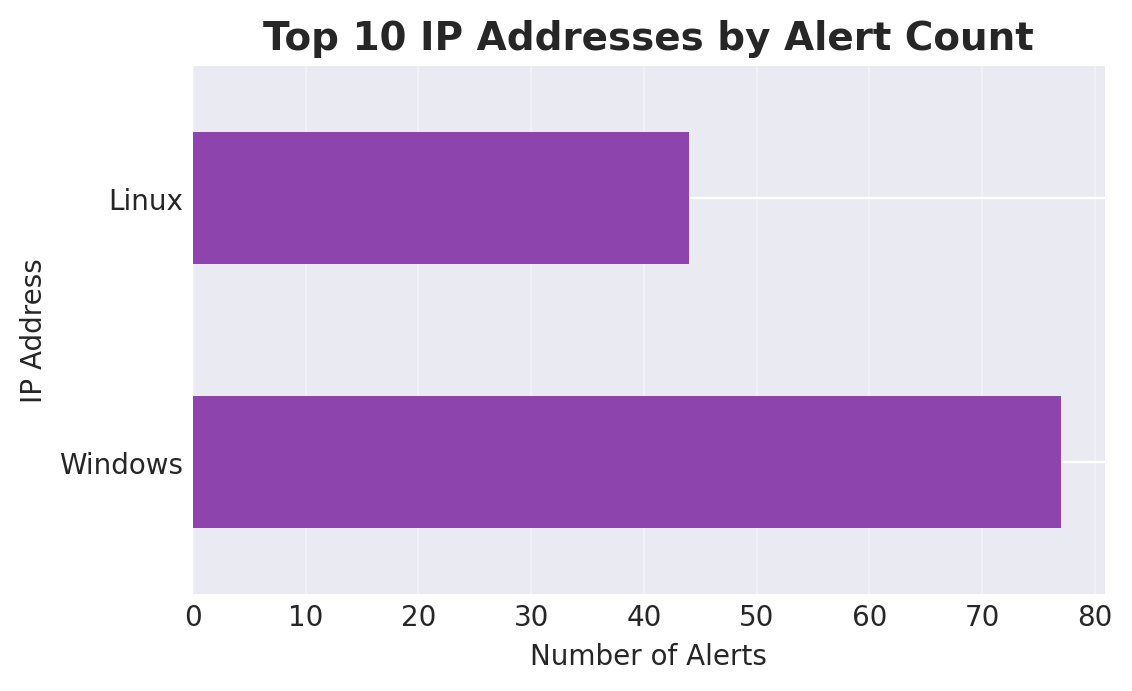

In [29]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# --- Plot 16: IP Address Analysis ---
ax16 = plt.subplot(6, 3, 16)

ip_counts = (
    df.groupby(['os_type'])
    .size()
    .sort_values(ascending=False)
    .head(10)
)

ip_counts.plot(kind='barh', ax=ax16, color='#8e44ad')

ax16.set_title('Top 10 IP Addresses by Alert Count', fontsize=14, fontweight='bold')
ax16.set_xlabel('Number of Alerts')
ax16.set_ylabel('IP Address')
ax16.grid(axis='x', alpha=0.3)

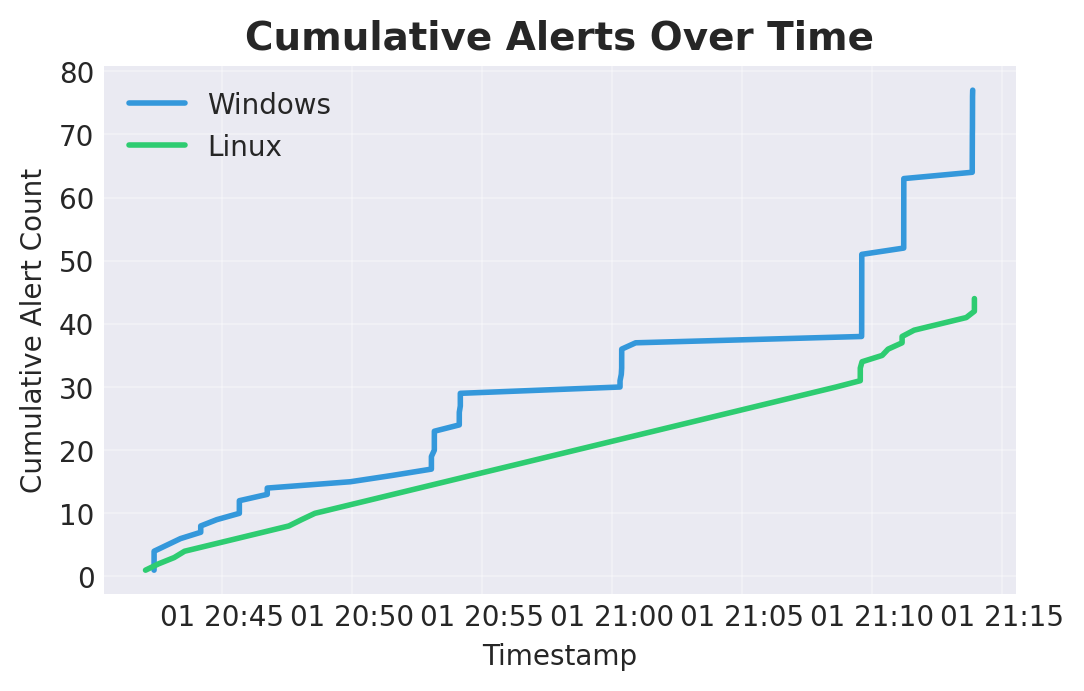

In [30]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# --- Plot 17: Cumulative Alerts Over Time ---
ax17 = plt.subplot(6, 3, 17)

# Compute cumulative alerts
windows_cumsum = windows_df.groupby('timestamp').size().cumsum()
linux_cumsum   = linux_df.groupby('timestamp').size().cumsum()

# Plot if data exists
if not windows_cumsum.empty:
    ax17.plot(
        windows_cumsum.index,
        windows_cumsum.values,
        label='Windows',
        linewidth=2,
        color='#3498db'
    )

if not linux_cumsum.empty:
    ax17.plot(
        linux_cumsum.index,
        linux_cumsum.values,
        label='Linux',
        linewidth=2,
        color='#2ecc71'
    )

# Formatting
ax17.set_title('Cumulative Alerts Over Time', fontsize=14, fontweight='bold')
ax17.set_xlabel('Timestamp')
ax17.set_ylabel('Cumulative Alert Count')
ax17.legend()
ax17.grid(True, alpha=0.3)


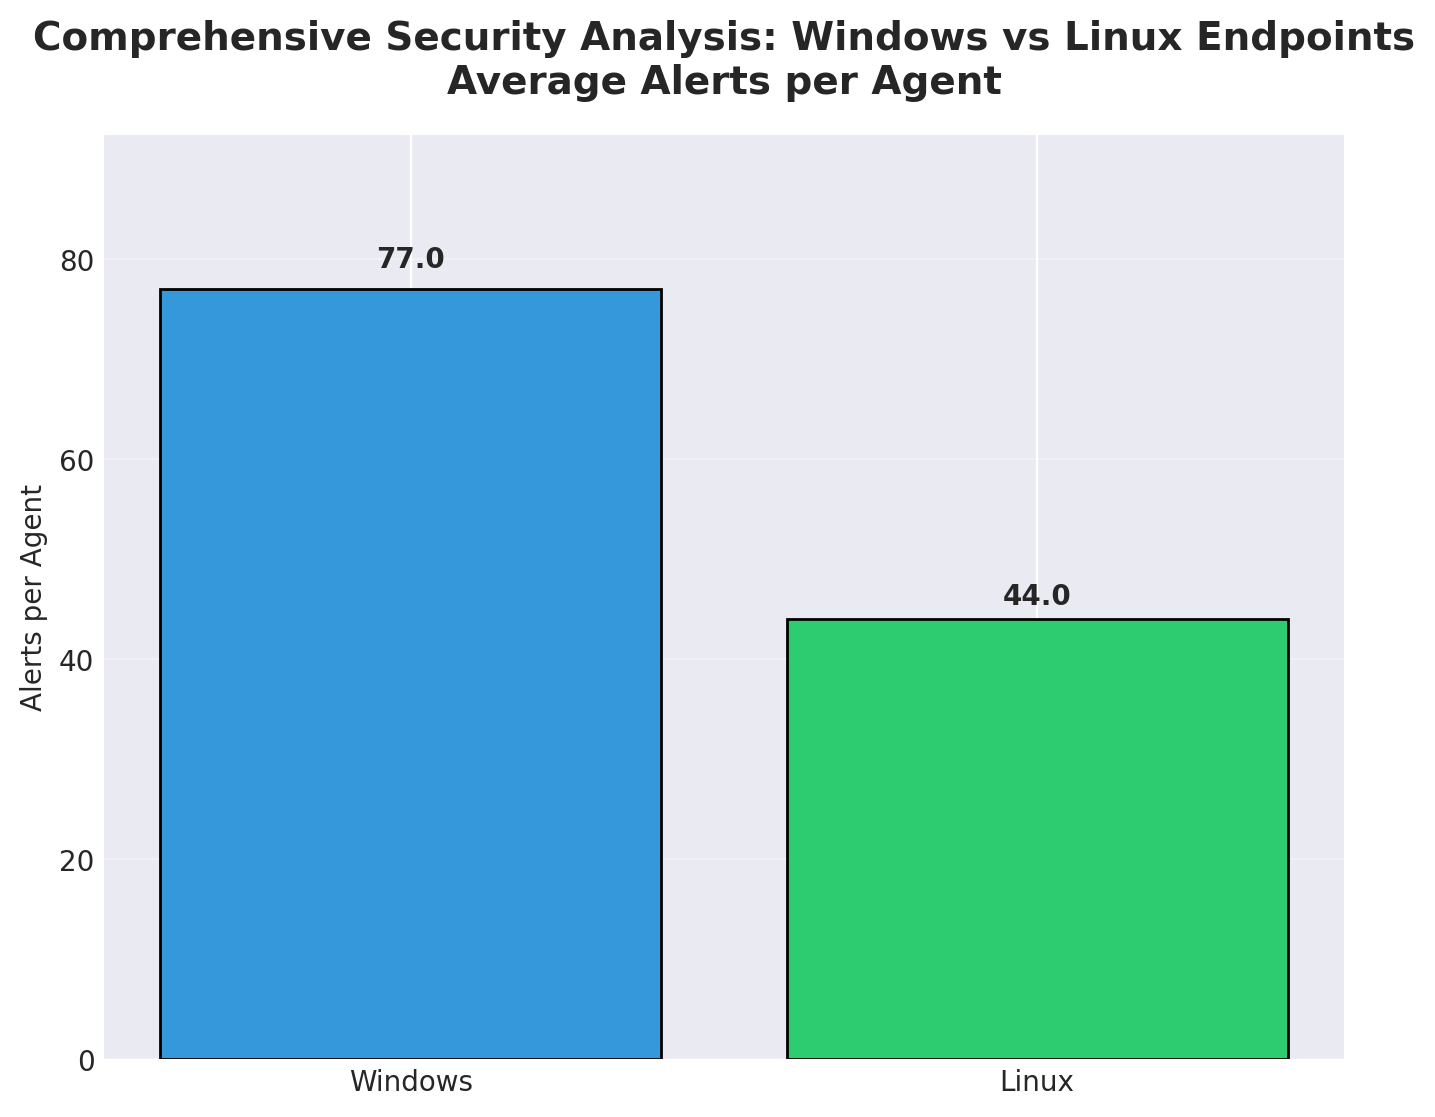

In [31]:
# --- Plot 18: Alert Rate Comparison (standalone) ---
fig18, ax18 = plt.subplots(figsize=(8, 6))  # standalone figure, nice size

# pick the right agent.id column
agent_id_col = 'agent.id' if 'agent.id' in windows_df.columns else 'agent\\.id'

windows_agents = windows_df[agent_id_col].nunique()
linux_agents   = linux_df[agent_id_col].nunique()

alerts_per_agent = pd.Series({
    'Windows': (len(windows_df) / windows_agents) if windows_agents > 0 else 0.0,
    'Linux':   (len(linux_df)   / linux_agents)   if linux_agents   > 0 else 0.0
})

bars = ax18.bar(
    alerts_per_agent.index,
    alerts_per_agent.values.astype(float),
    color=['#3498db', '#2ecc71'],
    edgecolor='black'
)

ax18.set_title(
    'Comprehensive Security Analysis: Windows vs Linux Endpoints\nAverage Alerts per Agent',
    fontsize=14, fontweight='bold',
    pad=15
)
ax18.set_ylabel('Alerts per Agent')
ax18.set_ylim(0, max(alerts_per_agent.values) * 1.2)
ax18.grid(axis='y', alpha=0.3)

for rect in bars:
    h = rect.get_height()
    ax18.text(
        rect.get_x() + rect.get_width()/2.0,
        h + (0.02 * h if h > 0 else 0.05),
        f'{h:.1f}',
        ha='center', va='bottom', fontweight='bold'
    )

plt.show()
